# Genome-scale characterization of RNA export

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/transcriptome_export"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load read counts

In [4]:
# Load read counts

infile = "../preprocessed_data/transcriptome_data/transcriptomics_supernatant/htseq.tab"

counts_raw = pd.read_csv(infile, sep="\t", header=0, index_col=0)

print(counts_raw.shape)
counts_raw.head()

(60766, 8)


,sFH14_1,sFH14_2,sFH14_3,sFH14_4,sFH14_5,sFH14_6,sFH14_7,sFH14_8
symbol,,,,,,,,
EGFP,60400,821,1067,12295,0,0,0,0
ENSG00000000003,6759,3981,52,83,26,41,23,14
ENSG00000000005,7,0,0,0,0,0,0,0
ENSG00000000419,819,296,0,74,14,15,13,21
ENSG00000000457,96,0,21,10,5,0,0,23


## Load mapping statistics

In [5]:
# Load mapping statistics

infile = "../preprocessed_data/transcriptome_data/transcriptomics_supernatant/STAR.tab"

star_raw = pd.read_csv(infile, sep="\t", header=0, index_col=0)

print(star_raw.shape)
star_raw.head()

(8, 6)


,input,uniquely_mapped,multiple_loci,too_many_loci,percent_unmapped_too_many_mismatches,percent_unmapped_too_short
name,,,,,,
sFH14_1,29498062,25301057,1105573,31043,0.00%,9.98%
sFH14_2,28151933,17902323,1282014,19533,0.00%,31.30%
sFH14_3,26252710,12856794,1254282,17713,0.00%,45.68%
sFH14_4,27937370,15697967,1191121,17020,0.00%,38.97%
sFH14_5,21550956,10610304,1931211,21308,0.00%,41.18%


## Load additional resources

In [6]:
# Load ERCC gene names

infile = "../resources/names_ERCC92.txt"

names_ERCC = []
with open(infile) as f:
    for line in f:
        names_ERCC.append(line.rstrip())
print("Loaded", len(names_ERCC), "gene names")

Loaded 92 gene names


## Specify sample information (names, colors)

In [7]:
# Set transgene names
names_transgenes = ["EGFP", "mCherry", "mTagBFP2"]

In [8]:
# Set sample labels
sample_to_label = {"sFH14_1": "MMLV Gag + mCh-Psi",
                   "sFH14_2": "Gag-MCP + mCh-MS2x8",
                   "sFH14_3": "GagZip-MCP + mCh-MS2x8",
                   "sFH14_4": "EPN24-MCP + mCh-MS2x8",
                   "sFH14_5": "mCh-Psi",
                   "sFH14_6": "mCh-MS2x8",
                   "sFH14_7": "No DNA",
                   "sFH14_8": "WT"}

# Set exporter labels
sample_to_exporter = {"sFH14_1": "MMLV Gag",
                   "sFH14_2": "Gag-MCP",
                   "sFH14_3": "GagZip-MCP",
                   "sFH14_4": "EPN24-MCP",
                   "sFH14_5": "No exporter (mCh-Psi)",
                   "sFH14_6": "No exporter (mCh-MS2x8)",
                   "sFH14_7": "No DNA",
                   "sFH14_8": "WT"}

# Set sample colors
sample_to_color = {"sFH14_1": "#3c955b",
                   "sFH14_2": "#a29fc2",
                   "sFH14_3": "#7b74aa",
                   "sFH14_4": "#563583",
                   "sFH14_5": "#8a8c8f",
                   "sFH14_6": "#8a8c8f",
                   "sFH14_7": "#c5c6c8",
                   "sFH14_8": "#c5c6c8"}

# Preprocess data

## Convert gene names from Ensembl to symbol

In [9]:
# Convert gene names from Ensembl to symbols (actually symbol underscore Ensembl ID)
df_ensembleToSymbol = pd.read_csv("../resources/Ensembl_to_symbol.csv", header=0, index_col=0, sep=",")
counts_raw["symbol_ensembl"] = df_ensembleToSymbol.loc[counts_raw.index]["symbol_ensembl"]
counts_raw.set_index("symbol_ensembl", inplace=True)

## Drop genes that are never observed

In [10]:
print(np.sum(counts_raw.sum(axis=1) == 0), "genes are never observed (count = 0 for all samples)")
print(np.mean(counts_raw.sum(axis=1) == 0)*100, "% of genes are never observed (count = 0 for all samples)")

39519 genes are never observed (count = 0 for all samples)
65.03472336503965 % of genes are never observed (count = 0 for all samples)


In [11]:
names_unmapped = ['__no_feature', '__ambiguous', '__too_low_aQual', '__not_aligned', '__alignment_not_unique']

names_not_observed = counts_raw.loc[counts_raw.sum(axis=1) == 0].index  # names of genes that were never observed
names_not_observed_clean = list(set(names_not_observed) - set(names_unmapped + names_ERCC + names_transgenes))  # remove names of special genes that we want to keep

counts_raw = counts_raw.drop(names_not_observed_clean)  # drop genes

print(counts_raw.shape)
counts_raw.head()

(21249, 8)


,sFH14_1,sFH14_2,sFH14_3,sFH14_4,sFH14_5,sFH14_6,sFH14_7,sFH14_8
symbol_ensembl,,,,,,,,
EGFP,60400,821,1067,12295,0,0,0,0
TSPAN6_ENSG00000000003,6759,3981,52,83,26,41,23,14
TNMD_ENSG00000000005,7,0,0,0,0,0,0,0
DPM1_ENSG00000000419,819,296,0,74,14,15,13,21
SCYL3_ENSG00000000457,96,0,21,10,5,0,0,23


## Calculate more useful mapping statistics

In [12]:
# Calculate additional useful metrics from STAR output
star_raw["frac_uniquely_mapped"] = star_raw["uniquely_mapped"] / star_raw["input"]
star_raw["percent_uniquely_mapped"] = 100 * star_raw["frac_uniquely_mapped"]

## Calculate CPM 

In [13]:
counts_cpm = counts_raw.copy()  # work with a copy of the counts, so we don't touch the raw counts

# Drop symbols for mapping reporting
counts_cpm = counts_cpm.drop(names_unmapped, axis=0)

# Normalize by total read number
counts_cpm = counts_cpm / counts_cpm.sum(axis=0)

# Multiply by 1e6 to get counts per million
counts_cpm = 1e6 * counts_cpm

## Drop ERCCs (for calculating relative abundance)

In [14]:
counts_NoERCC = counts_raw.copy()  # work with a copy of the counts, so we don't touch the raw counts

# Drop symbols for mapping reporting
counts_NoERCC = counts_NoERCC.drop(names_unmapped, axis=0)

# Drop symbols for mapping reporting
counts_NoERCC = counts_NoERCC.drop(names_ERCC, axis=0)

print(counts_NoERCC.shape)

(21152, 8)


# Plot mapping statistics

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


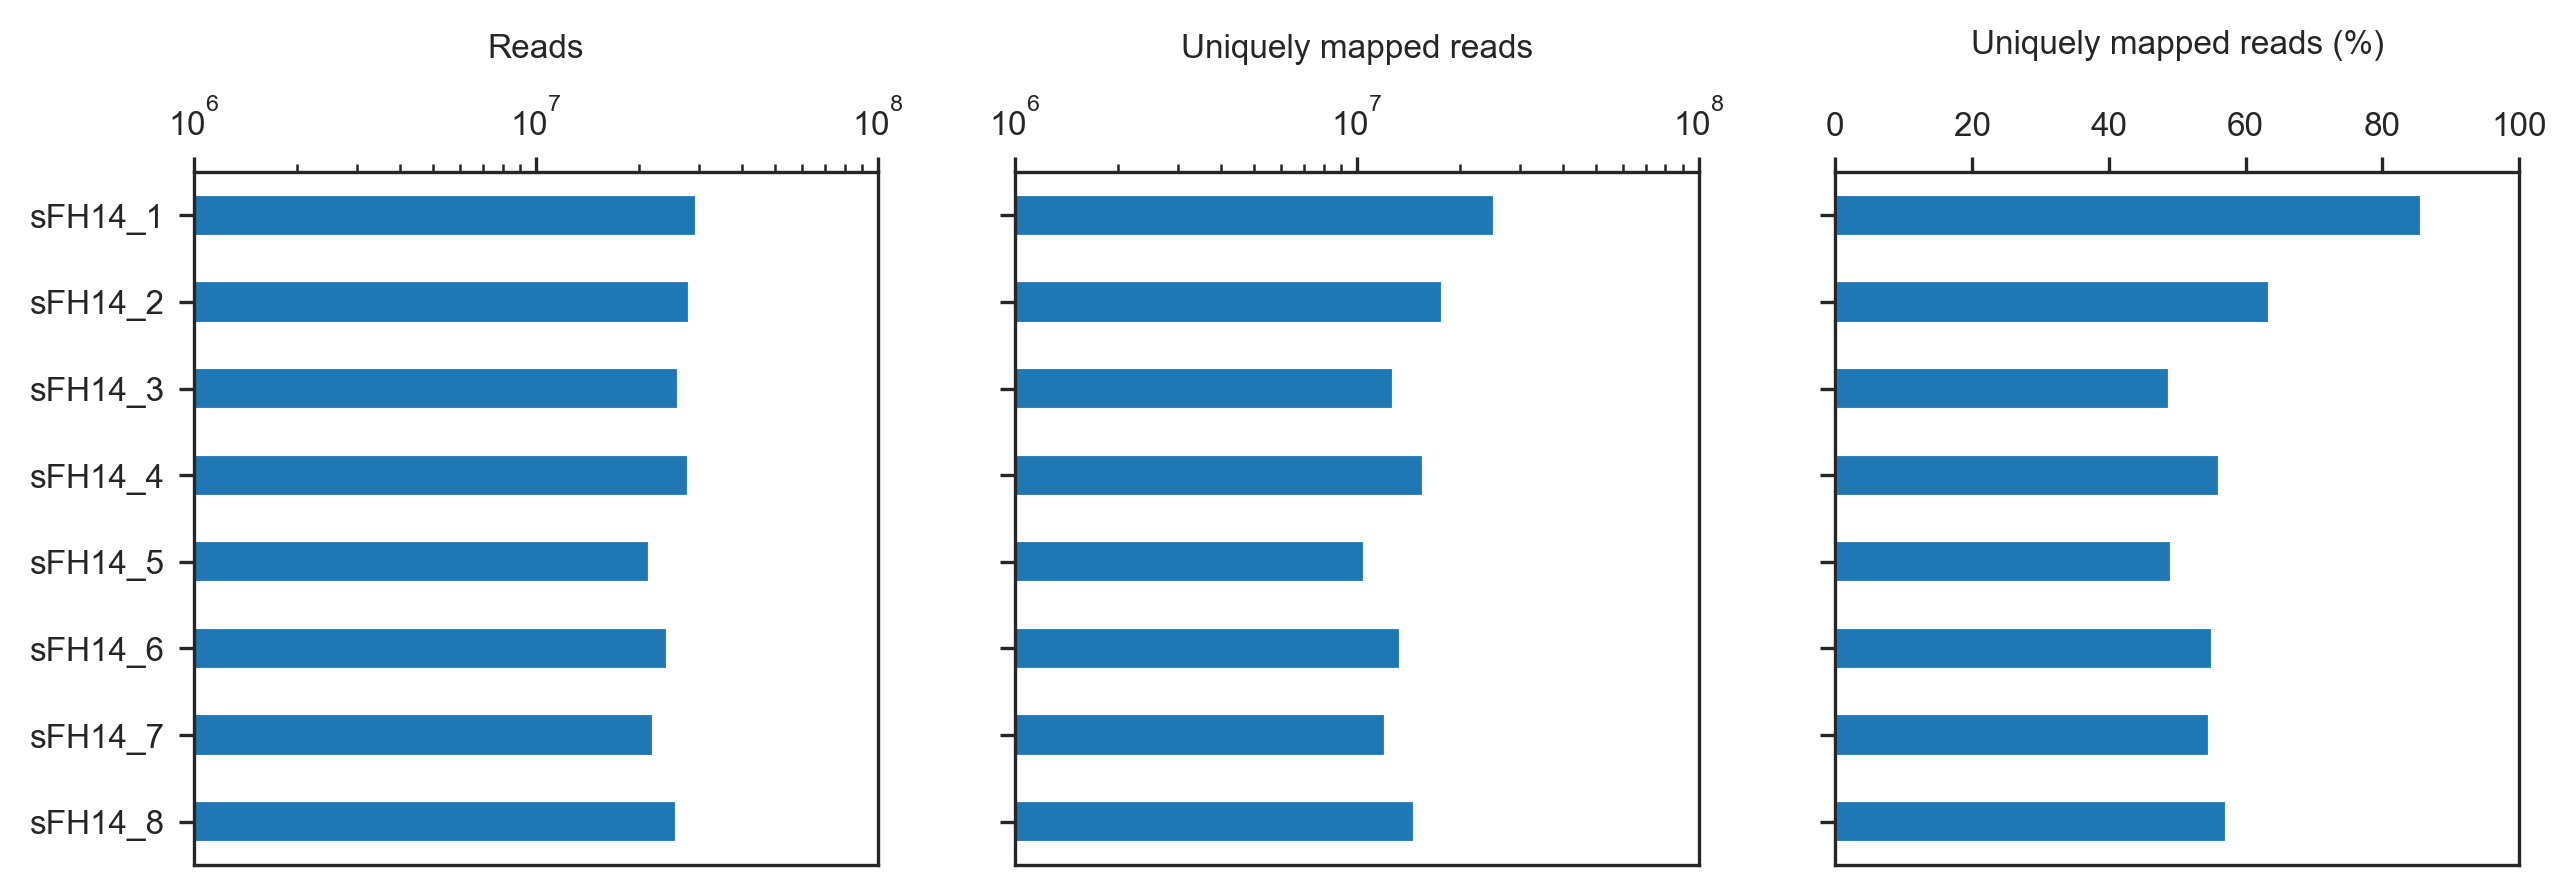

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(10,3), sharey=True)

ax = axes[0]
star_raw.input.plot(ax=ax, kind="barh", log=True)
ax.invert_yaxis()
ax.set_xscale("log")
ax.set_xlim(1e6, 1e8)
ax.xaxis.tick_top()
ax.set_xlabel("Reads", labelpad=10)
ax.xaxis.set_label_position('top')
ax.set_ylabel("")

ax = axes[1]
star_raw.uniquely_mapped.plot(ax=ax, kind="barh")
ax.invert_yaxis()
ax.set_xscale("log")
ax.set_xlim(1e6, 1e8)
ax.xaxis.tick_top()
ax.set_xlabel("Uniquely mapped reads", labelpad=10)
ax.xaxis.set_label_position('top') 

ax = axes[2]
star_raw.percent_uniquely_mapped.plot(ax=ax, kind="barh")
ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.xaxis.tick_top()
ax.set_xlabel("Uniquely mapped reads (%)", labelpad=14)
ax.xaxis.set_label_position('top')

# Normalize abundances across samples using ERCC standards

## Select ERCCs and calculate summary statistics

In [16]:
# Select subset of data consisting of ERCCs
counts_ERCC = counts_cpm.loc[names_ERCC].copy()

# Calculate mean level of each ERCC
mean_counts_ERCC = np.mean(counts_ERCC, axis=1)

# Sort ERCCs by mean level
counts_ERCC = counts_ERCC.loc[mean_counts_ERCC.sort_values(ascending=False).index]

print(counts_ERCC.shape)
counts_ERCC.head()

(92, 8)


,sFH14_1,sFH14_2,sFH14_3,sFH14_4,sFH14_5,sFH14_6,sFH14_7,sFH14_8
symbol_ensembl,,,,,,,,
ERCC-00074,26308.117576,131955.787949,297592.077448,205582.933778,217948.485343,236844.961195,212200.779805,212957.421058
ERCC-00130,15028.600786,69471.987874,144110.372856,104180.542541,167557.823289,163574.773439,172512.987905,178202.729560
ERCC-00096,11196.030414,51449.928422,102937.035567,80344.592664,144597.516226,134529.353038,141593.190476,154246.879378
ERCC-00002,8730.070739,42211.977814,84257.703837,70288.042131,113985.088205,108822.576378,112401.865882,112604.283196
ERCC-00171,7596.063426,46506.985079,99520.412567,84838.603014,96933.373380,87976.580136,86656.708791,75741.223516


## Plot ERCC abundances (before normalization)

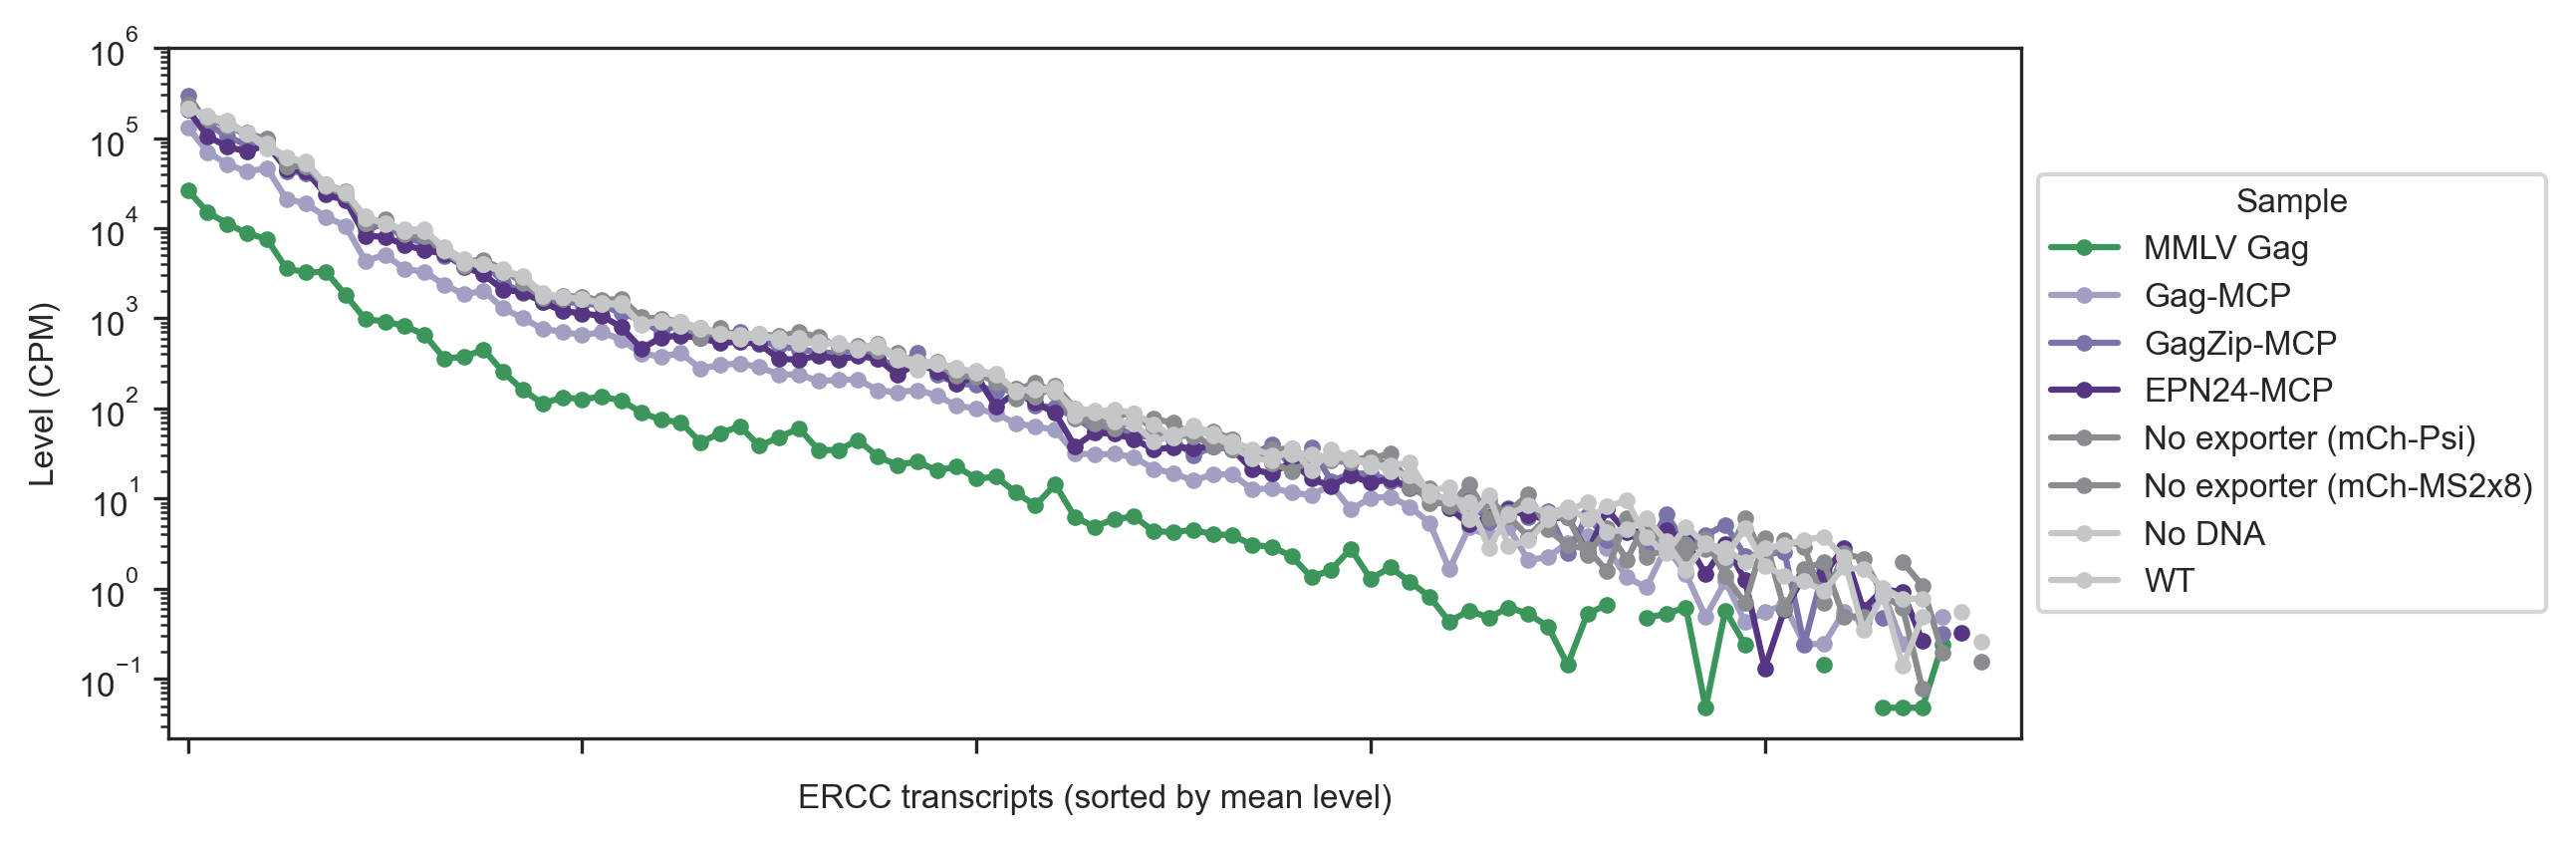

In [17]:
# Copy data
temp = counts_ERCC.copy()

# Set colors
color = [sample_to_color[x] for x in temp.columns]

# Rename columns with informative names
temp = temp.rename(columns=sample_to_exporter)

# Drop zero values (causes lines dragging to bottom of plot when log-scaled)
temp[temp == 0] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(8,3))
temp.plot(ax=ax, marker=".", linestyle=None,
          color=color)
ax.set_yscale("log")
ax.set_ylim(top=1e6)
ax.set_xlim(-1,counts_ERCC.shape[0]+1)
ax.set_xlabel("ERCC transcripts (sorted by mean level)")
ax.set_ylabel("Level (CPM)")
ax.set_xticklabels([])
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), title="Sample")

sFH14_1     87280.984695
sFH14_2    438365.972146
sFH14_3    933831.815940
sFH14_4    735950.874679
sFH14_5    971013.169450
sFH14_6    973176.068020
sFH14_7    979280.744566
sFH14_8    986464.551736
dtype: float64

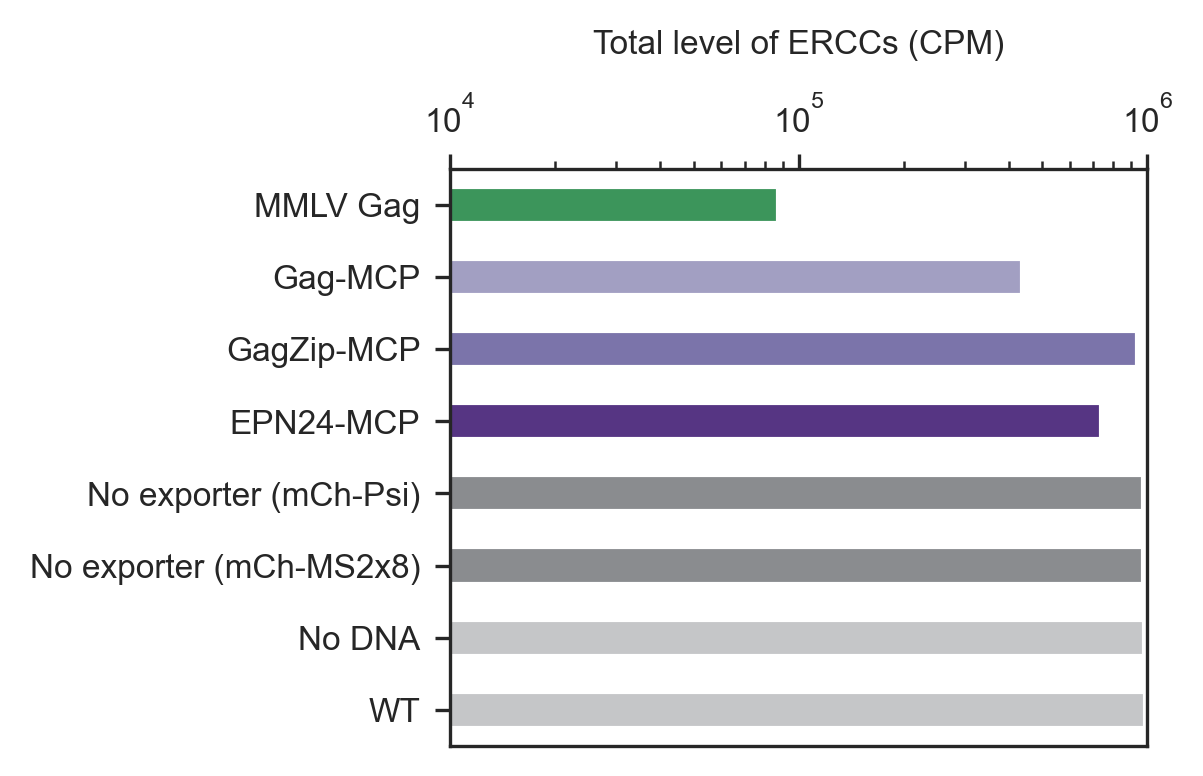

In [18]:
# Plot total abundance of ERCCs in each sample

x = np.sum(counts_ERCC)

color = [sample_to_color[_] for _ in x.index]
label = [sample_to_exporter[_] for _ in x.index]

fig, ax = plt.subplots(1, 1, figsize=(3,2.5))
x.plot(ax=ax, kind="barh", color=color)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xscale("log")
ax.set_xlim(1e4, 1e6)
ax.set_xlabel("Total level of ERCCs (CPM)", labelpad=10)
ax.set_yticklabels(label)

x

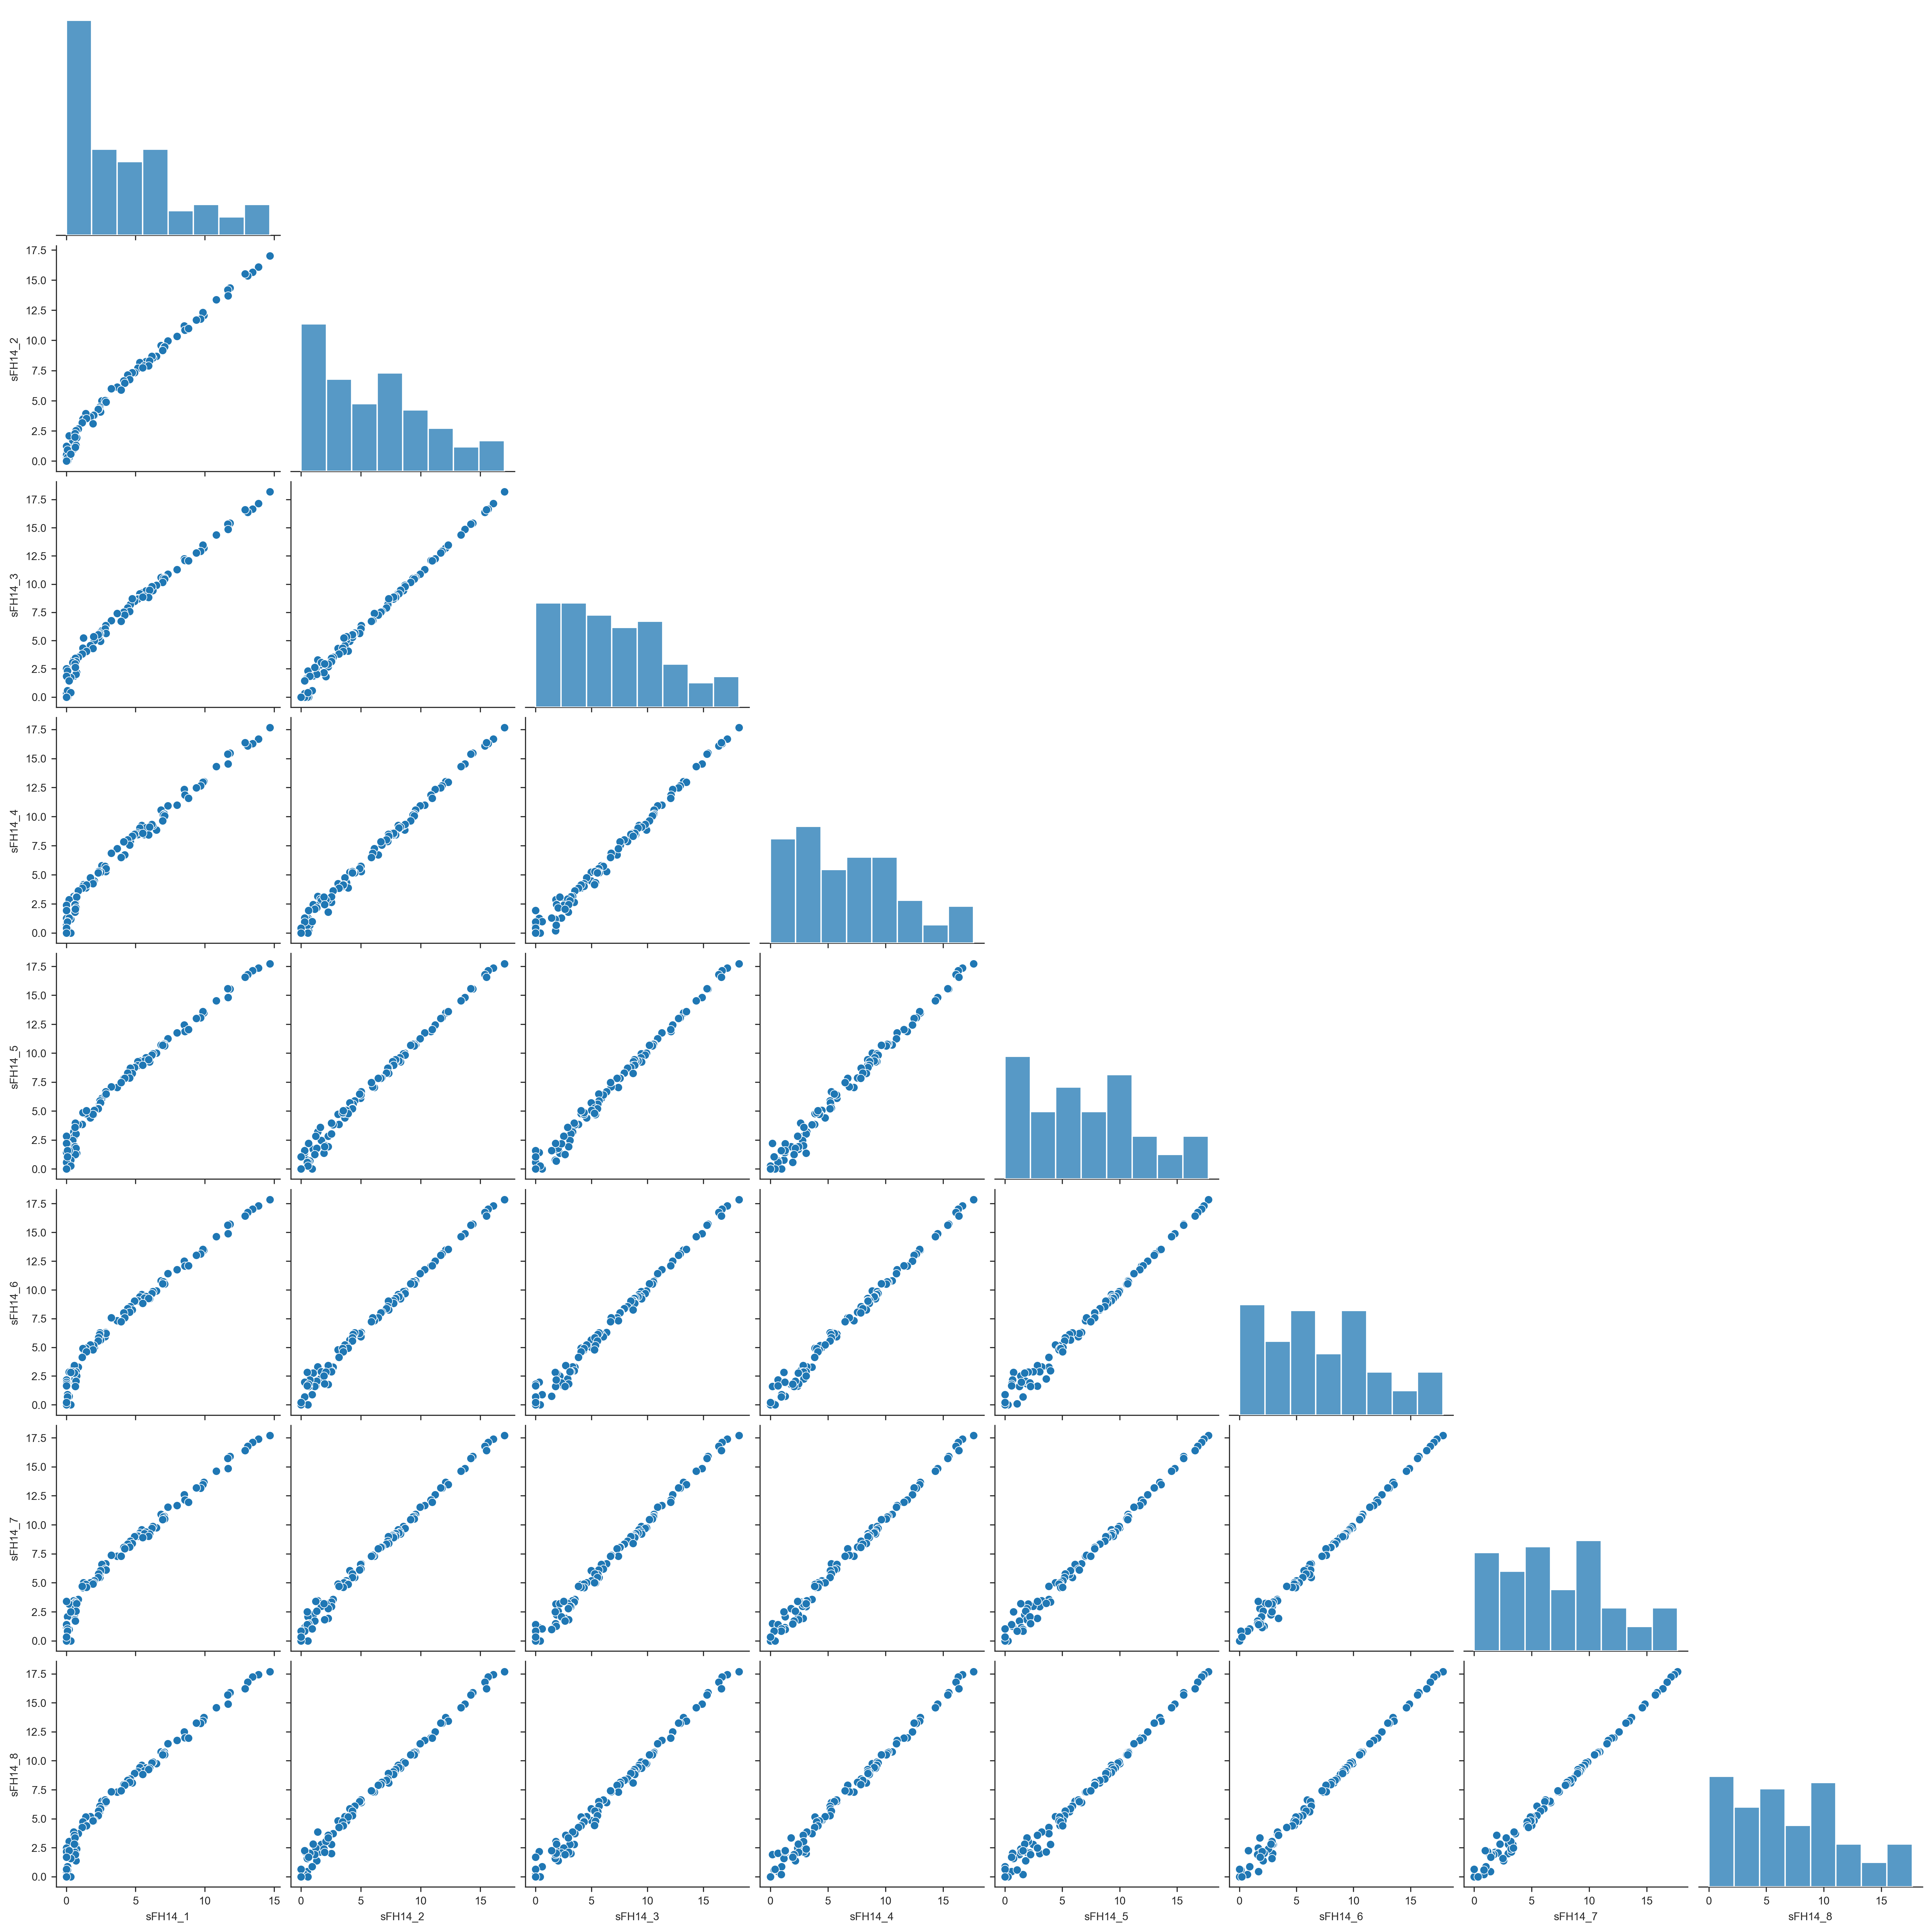

In [19]:
# Visualize ERCC levels in pairs of samples (log2(CPM+1) scale)
sns.pairplot(np.log2(counts_ERCC + 1), corner=True)

These plots reveal that the relative abundance of the ERCC spike-in standard is dramatically lower in the samples with efficient RNA export, as expected. We proceed with normalizing abundances across samples using the assumption that ERCC spike-in standards are present at equivalent levels.

## Normalize expression levels using ERCCs as reference

In [20]:
# Choose reference sample
sample_ref = "sFH14_7"  # Mock transfected (no DNA) sample

# Calculate ratio of ERCCs in each sample to reference
ratio_ERCC = counts_ERCC.div(counts_ERCC[sample_ref], axis=0)
ratio_ERCC

,sFH14_1,sFH14_2,sFH14_3,sFH14_4,sFH14_5,sFH14_6,sFH14_7,sFH14_8
symbol_ensembl,,,,,,,,
ERCC-00074,0.123977,0.621844,1.402408,0.968813,1.027086,1.116136,1.0,1.003566
ERCC-00130,0.087116,0.402706,0.835360,0.603900,0.971277,0.948188,1.0,1.032982
ERCC-00096,0.079072,0.363364,0.726991,0.567433,1.021218,0.950112,1.0,1.089367
ERCC-00002,0.077668,0.375545,0.749611,0.625328,1.014085,0.968156,1.0,1.001801
ERCC-00171,0.087657,0.536681,1.148444,0.979019,1.118591,1.015231,1.0,0.874038
...,...,...,...,...,...,...,...,...
ERCC-00098,0.061687,0.314212,0.000000,1.184522,2.541267,0.796284,1.0,0.180182
ERCC-00075,0.061687,0.000000,0.000000,0.338435,1.397697,0.099535,1.0,0.630636
ERCC-00048,inf,inf,inf,NaN,inf,NaN,NaN,NaN


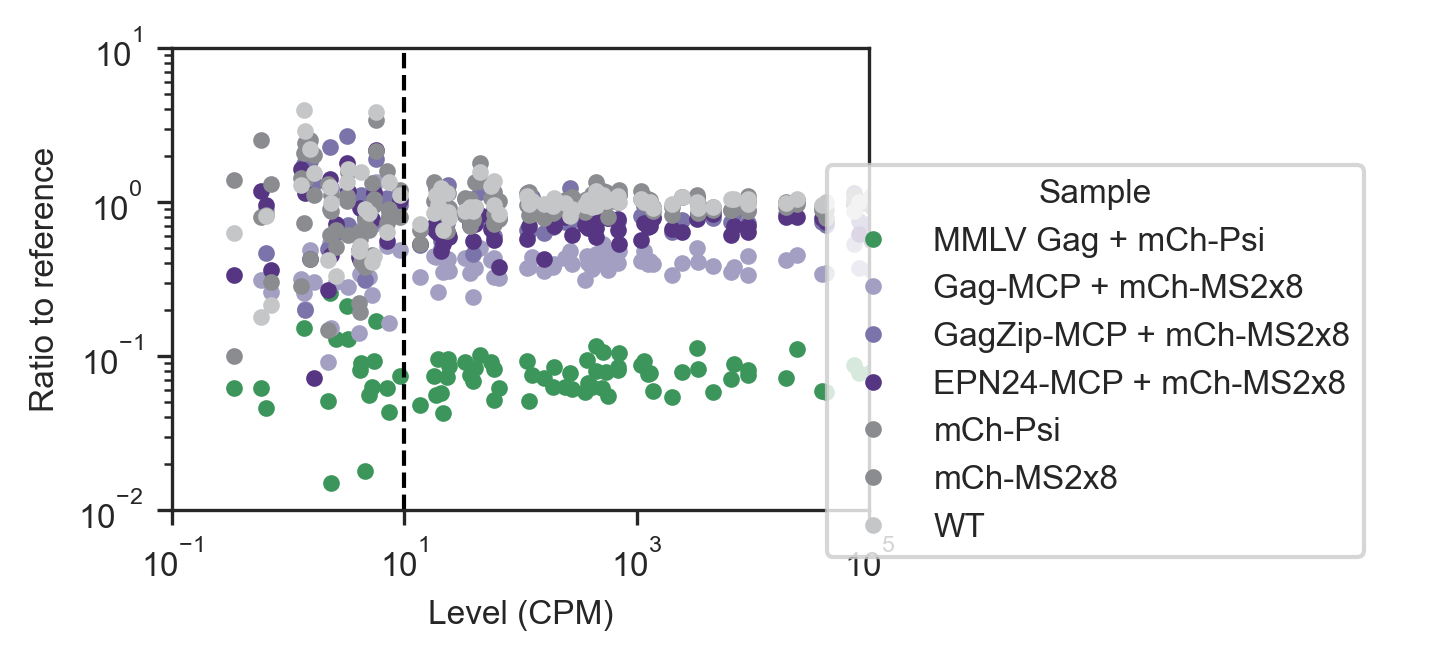

In [21]:
# Visualize ratio to reference versus mean level (pretty plot)

data = ratio_ERCC.copy()
data["mean"] = mean_counts_ERCC.loc[ratio_ERCC.index]  # add mean as a new column

samples = counts_raw.columns  # get sample names

fig, ax = plt.subplots(1, 1, figsize=(3,2))

for sample in samples:
    
    if sample == sample_ref: continue  # skip reference
    
    x = data["mean"]  # get mean
    y = data[sample]  # get ratio
    label = sample_to_label[sample]
    color = sample_to_color[sample]
    ax.plot(x, y, label=label, color=color, marker=".", ls="None")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, 1e5)
ax.set_ylim(1e-2, 1e1)

ax.set_xlabel("Level (CPM)")
ax.set_ylabel("Ratio to reference")

fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5), title="Sample")

ax.axvline(10, ls="--", color="k", lw=1)  # cutoff beyond which ratio is stable

In [22]:
# Choose a reasonable cutoff for ERCC level on which to calculate a correction ratio
mean_ERCC_cutoff = 10

# Get names of ERCCs above cutoff
names_ERCC_above_cutoff = mean_counts_ERCC.loc[mean_counts_ERCC > mean_ERCC_cutoff].index

print(len(names_ERCC_above_cutoff), "ERCCs are above cutoff for correction")

# Examine correction ratios for chosen ERCCs
ratio_ERCC.loc[names_ERCC_above_cutoff]

63 ERCCs are above cutoff for correction


,sFH14_1,sFH14_2,sFH14_3,sFH14_4,sFH14_5,sFH14_6,sFH14_7,sFH14_8
symbol_ensembl,,,,,,,,
ERCC-00002,0.077668,0.375545,0.749611,0.625328,1.014085,0.968156,1.0,1.001801
ERCC-00003,0.089039,0.381813,0.832205,0.704026,0.920713,0.961155,1.0,1.044320
ERCC-00004,0.111189,0.450506,1.012278,0.800316,0.974571,1.035021,1.0,1.040243
ERCC-00009,0.058206,0.382695,0.783330,0.839520,0.892553,0.932491,1.0,0.930588
ERCC-00014,0.082446,0.436039,0.908617,0.728648,1.161374,0.834667,1.0,1.367224
...,...,...,...,...,...,...,...,...
ERCC-00162,0.084958,0.398813,0.705983,0.704809,0.860625,0.991635,1.0,1.058975
ERCC-00163,0.050945,0.380396,0.649893,0.695573,0.819817,1.159707,1.0,0.972728
ERCC-00165,0.061798,0.461485,0.915558,0.830934,1.034191,1.083576,1.0,1.094616


In [23]:
# Calculate mean correction ratio for each sample
correction_ratio = scipy.stats.gmean(ratio_ERCC.loc[names_ERCC_above_cutoff])
correction_ratio

array([0.07556446, 0.40120985, 0.82956418, 0.69292993, 0.96303932,
       0.99309771, 1.        , 0.99151917])

In [24]:
# Normalize expression levels to ERCCs by applying correction ratio to counts
counts_cpm_norm = counts_cpm / correction_ratio
counts_cpm_norm.head()

,sFH14_1,sFH14_2,sFH14_3,sFH14_4,sFH14_5,sFH14_6,sFH14_7,sFH14_8
symbol_ensembl,,,,,,,,
EGFP,38263.834609,124.741603,103.242580,1165.015095,0.000000,0.000000,0.000000,0.000000
TSPAN6_ENSG00000000003,4281.875135,604.867628,5.031503,7.864681,2.662116,3.188945,1.983182,0.987155
TNMD_ENSG00000000005,4.434550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DPM1_ENSG00000000419,518.842393,44.973830,0.000000,7.011884,1.433447,1.166687,1.120929,1.480732
SCYL3_ENSG00000000457,60.816691,0.000000,2.031953,0.947552,0.511945,0.000000,0.000000,1.621754


## Plot normalized ERCC abundances (verify appropriate normalization)

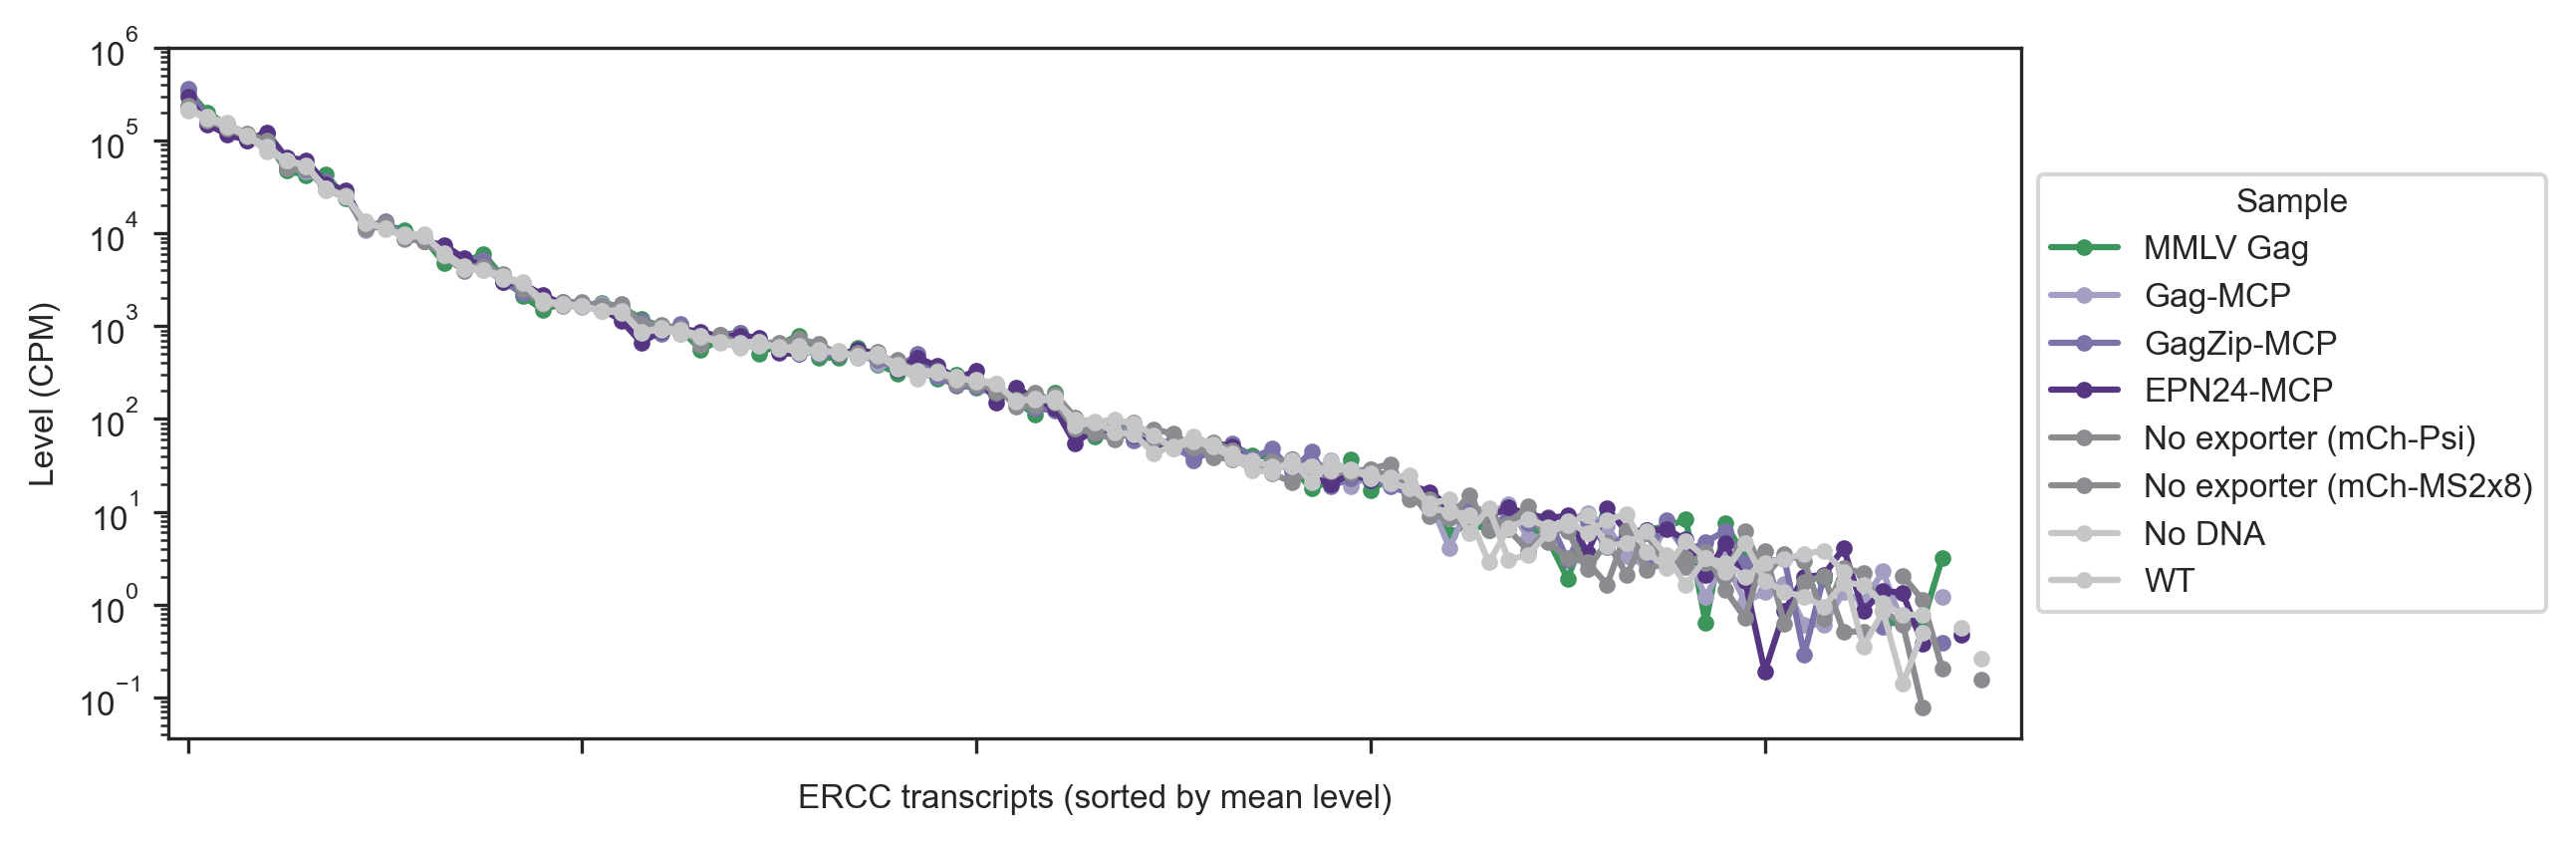

In [25]:
# Make temporary data in proper format
temp = counts_cpm_norm.loc[counts_ERCC.index].copy()

# Set colors
color = [sample_to_color[x] for x in temp.columns]

# Rename columns with informative names
temp = temp.rename(columns=sample_to_exporter)

# Drop zero values (causes lines dragging to bottom of plot when log-scaled)
temp[temp == 0] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(8,3))
temp.plot(ax=ax, marker=".", linestyle=None,
          color=color)
ax.set_yscale("log")
ax.set_ylim(top=1e6)
ax.set_xlim(-1,counts_ERCC.shape[0]+1)
ax.set_xlabel("ERCC transcripts (sorted by mean level)")
ax.set_ylabel("Level (CPM)")
ax.set_xticklabels([])
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), title="Sample")

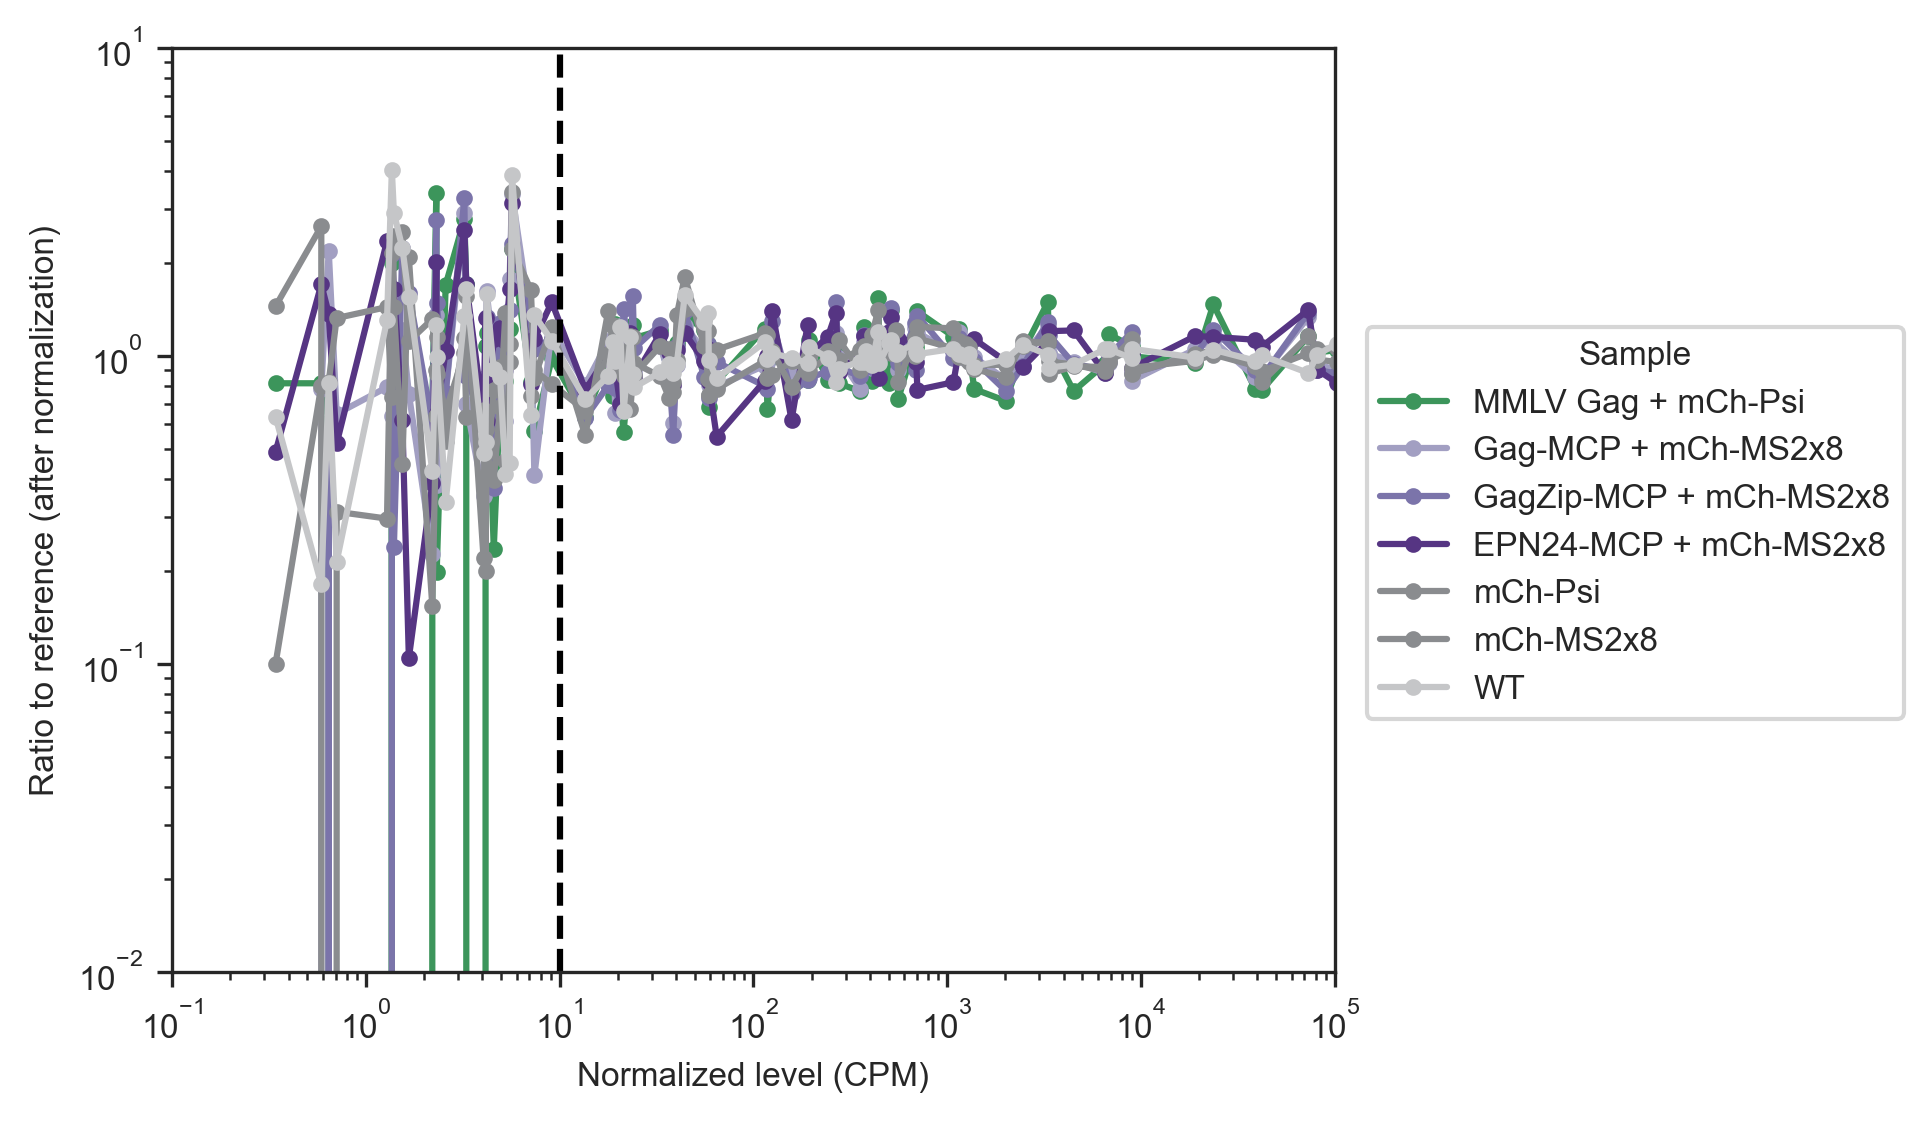

In [26]:
# Visualize ratio to reference versus mean level

# Calculate ratio of ERCCs in each sample to reference (should be ~1 for all ERCCs)
ratio_ERCC_norm = counts_cpm_norm.loc[counts_ERCC.index].div(counts_cpm_norm.loc[counts_ERCC.index, sample_ref], axis=0)

data = ratio_ERCC_norm.copy()
data["mean"] = mean_counts_ERCC.loc[ratio_ERCC_norm.index]  # add mean as a new column

samples = counts_raw.columns  # get sample names

fig, ax = plt.subplots(1, 1, figsize=(5,4))

for sample in samples:
    
    if sample == sample_ref: continue  # skip reference
    
    x = data["mean"]  # get mean
    y = data[sample]  # get ratio
    label = sample_to_label[sample]
    color = sample_to_color[sample]
    ax.plot(x, y, label=label, color=color, marker=".")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, 1e5)
ax.set_ylim(1e-2, 1e1)

ax.set_xlabel("Normalized level (CPM)")
ax.set_ylabel("Ratio to reference (after normalization)")

fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5), title="Sample")

ax.axvline(10, ls="--", color="k")  # cutoff beyond which ratio is stable

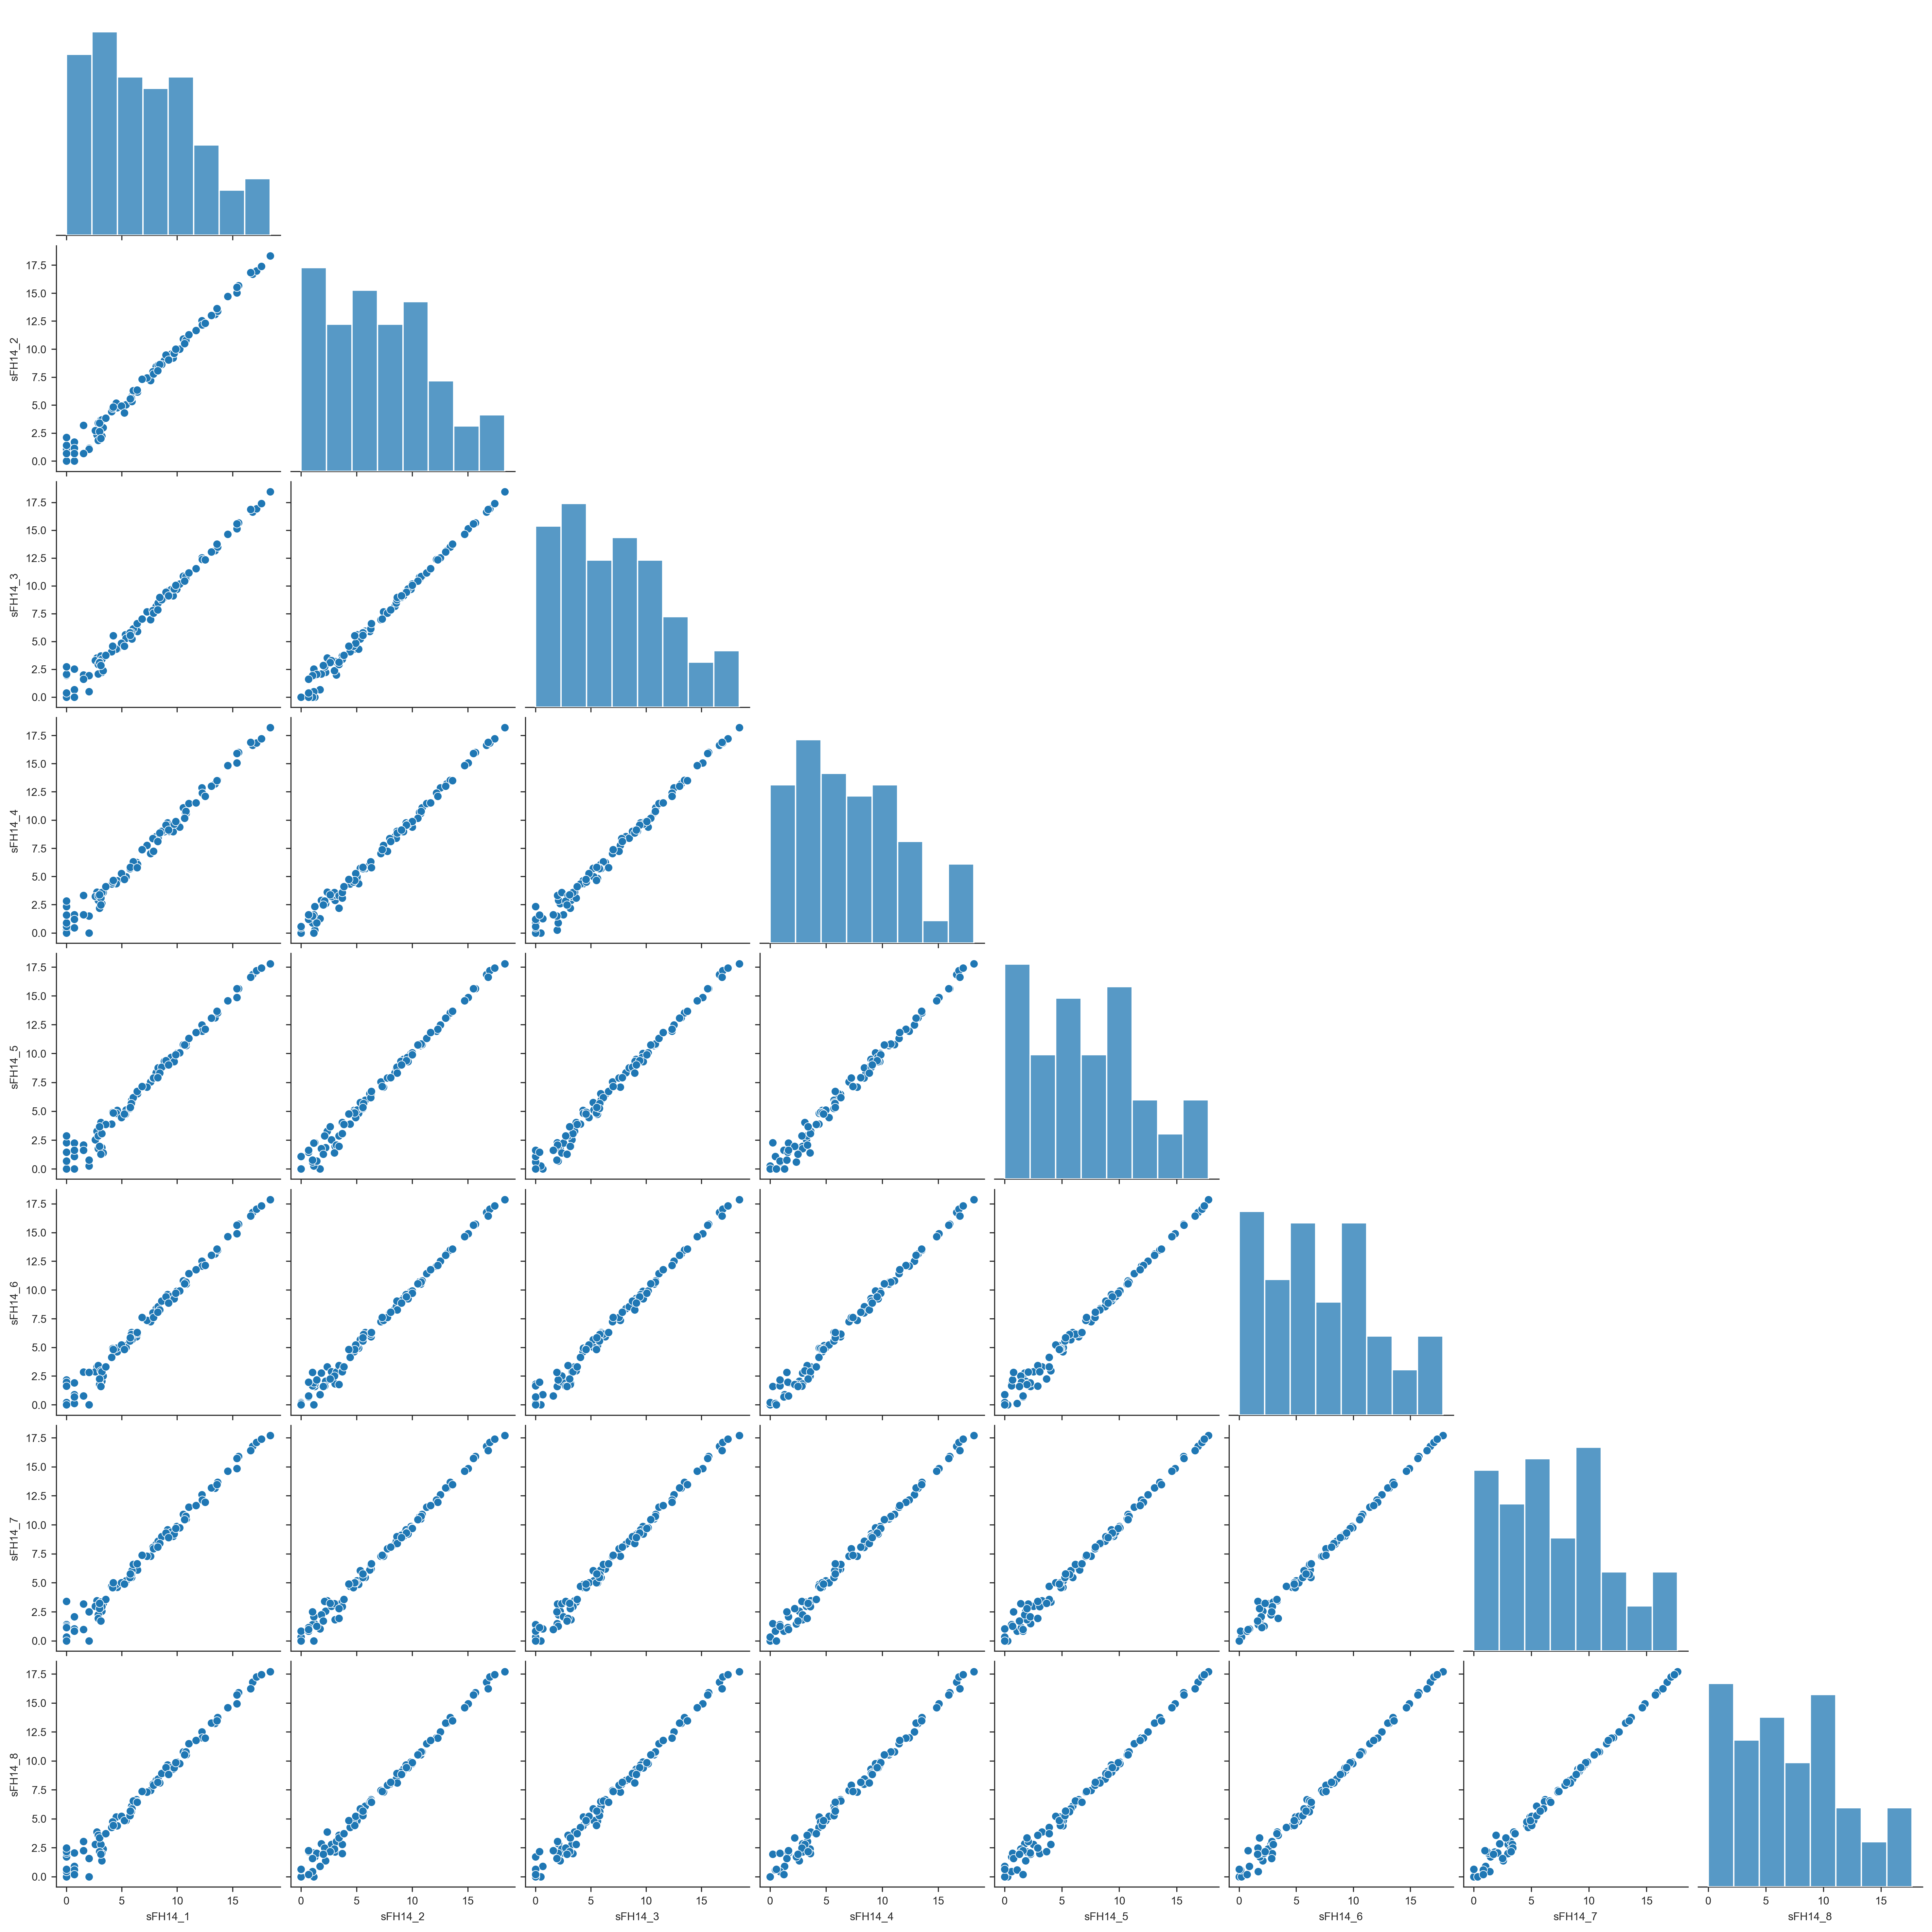

In [27]:
# Visualize normalized ERCC levels in pairs of samples (log2(CPM+1) scale)
sns.pairplot(np.log2(counts_cpm_norm.loc[names_ERCC] + 1), corner=True)

# Preprocess normalized abundances

We calculate various further normalizations and transformations of the normalized abundances.

## Log-transform abundances after normalization

In [28]:
# Calculate log2(CPM + 1) after re-normalization
counts = np.log2(counts_cpm_norm + 1)
print(counts.shape)
counts.head()

(21244, 8)


,sFH14_1,sFH14_2,sFH14_3,sFH14_4,sFH14_5,sFH14_6,sFH14_7,sFH14_8
symbol_ensembl,,,,,,,,
EGFP,15.223732,6.974318,6.703801,10.187371,0.000000,0.000000,0.000000,0.000000
TSPAN6_ENSG00000000003,12.064364,9.242859,2.592518,3.148069,1.872678,2.066587,1.576852,0.990704
TNMD_ENSG00000000005,2.442161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DPM1_ENSG00000000419,9.021930,5.522741,0.000000,3.002142,1.283002,1.115491,1.084696,1.310766
SCYL3_ENSG00000000457,5.949925,0.000000,1.600248,0.961662,0.596406,0.000000,0.000000,1.390532


## Re-normalize to CPM and log-transform abundances after normalization

In [29]:
# After normalization, total abundance per sample now varies across samples
counts_cpm_norm.sum()

sFH14_1    1.323373e+07
sFH14_2    2.492461e+06
sFH14_3    1.205452e+06
sFH14_4    1.443147e+06
sFH14_5    1.038379e+06
sFH14_6    1.006950e+06
sFH14_7    1.000000e+06
sFH14_8    1.008553e+06
dtype: float64

In [30]:
# To facilitate interpretation of the data, we normalize the sum of all counts to 1M again

counts_cpm_norm_renorm = counts_cpm_norm.copy()  # work with a copy of the counts, so we don't touch the raw counts

# Normalize to total of 1M counts
counts_cpm_norm_renorm = counts_cpm_norm_renorm / counts_cpm_norm_renorm.sum()

# Multiply by 1e6 to get counts per million
counts_cpm_norm_renorm = 1e6 * counts_cpm_norm_renorm

## Drop ERCCs and normalize without ERCCs

In [31]:
# Drop ERCCs
counts_cpm_norm_NoERCC = counts_cpm_norm.drop(names_ERCC)

In [32]:
# To examine relative abundance of genes in supernatant, we normalize counts after removing ERCC spike-ins

counts_cpm_norm_NoERCC_norm = counts_cpm_norm_NoERCC.copy()  # work with a copy of the counts, so we don't touch the raw counts

# Normalize to a total of 1M counts
counts_cpm_norm_NoERCC_norm = counts_cpm_norm_NoERCC / counts_cpm_norm_NoERCC.sum()

# Multiply by 1e6 to get counts per million
counts_cpm_norm_NoERCC_norm = 1e6 * counts_cpm_norm_NoERCC_norm

## Rescale counts (to obtain counts per million of ERCC)

In [33]:
# Total counts of ERCC vary across samples
# Here, we rescale so that all samples have 1M counts of ERCC (such that all abundances are counts per million counts of ERCC)
counts_cpm_norm.loc[names_ERCC].sum(axis=0)

sFH14_1    1.155053e+06
sFH14_2    1.092610e+06
sFH14_3    1.125690e+06
sFH14_4    1.062086e+06
sFH14_5    1.008280e+06
sFH14_6    9.799399e+05
sFH14_7    9.792807e+05
sFH14_8    9.949021e+05
dtype: float64

In [34]:
f = 1/counts_cpm_norm.loc[names_ERCC].sum(axis=0) * 1e6  # calculate rescaling factors
f

sFH14_1    0.865761
sFH14_2    0.915240
sFH14_3    0.888344
sFH14_4    0.941544
sFH14_5    0.991788
sFH14_6    1.020471
sFH14_7    1.021158
sFH14_8    1.005124
dtype: float64

In [35]:
counts_cpm_norm_scaled = counts_cpm_norm * f
print(counts_cpm_norm_scaled.shape)
counts_cpm_norm_scaled.head()

(21244, 8)


,sFH14_1,sFH14_2,sFH14_3,sFH14_4,sFH14_5,sFH14_6,sFH14_7,sFH14_8
symbol_ensembl,,,,,,,,
EGFP,33127.329608,114.168443,91.714959,1096.912657,0.000000,0.000000,0.000000,0.000000
TSPAN6_ENSG00000000003,3707.079815,553.598746,4.469707,7.404941,2.640255,3.254225,2.025142,0.992213
TNMD_ENSG00000000005,3.839260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DPM1_ENSG00000000419,449.193426,41.161826,0.000000,6.601996,1.421676,1.190570,1.144645,1.488319
SCYL3_ENSG00000000457,52.652709,0.000000,1.805074,0.892162,0.507741,0.000000,0.000000,1.630064


In [36]:
# Confirm that total counts of ERCCs is 1M in all samples
counts_cpm_norm_scaled.loc[names_ERCC].sum(axis=0)

sFH14_1    1000000.0
sFH14_2    1000000.0
sFH14_3    1000000.0
sFH14_4    1000000.0
sFH14_5    1000000.0
sFH14_6    1000000.0
sFH14_7    1000000.0
sFH14_8    1000000.0
dtype: float64

In [37]:
# Confirm that total counts varies across samples (reflecting relative abundance of total RNA)
counts_cpm_norm_scaled.sum(axis=0)

sFH14_1    1.145725e+07
sFH14_2    2.281199e+06
sFH14_3    1.070857e+06
sFH14_4    1.358786e+06
sFH14_5    1.029852e+06
sFH14_6    1.027563e+06
sFH14_7    1.021158e+06
sFH14_8    1.013721e+06
dtype: float64

# Plot relative abundance of reporter RNA in supernatant RNA

In [38]:
# Calculate relative abundance of each gene in supernatant

# In preprocessing above, we started with raw counts and dropped ERCCs.
# Here, to calculate the relative abundance of each gene, we normalize by the sum of the counts.
# This yields the fraction of reads mapping to each gene.

frac_NoERCC = counts_NoERCC.div(counts_NoERCC.sum(axis=0))

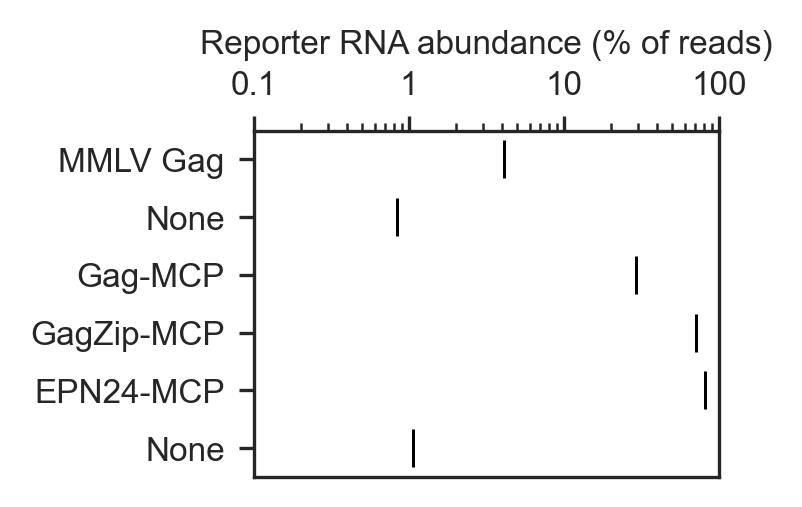

In [39]:
# All exporter

data = frac_NoERCC.loc["mCherry"] * 100  # convert to percentage
data = data[["sFH14_1", "sFH14_5", "sFH14_2", "sFH14_3", "sFH14_4", "sFH14_6"]]
data

fig, ax = plt.subplots(1, 1, figsize=(2,1.5))

x = data
y = np.arange(len(x))
sns.scatterplot(ax=ax, x=x, y=y, marker="|", s=80, color="k")

ax.set_xscale("log")
ax.set_xlim(1e-1, 1e2)

ax.set_ylim(-0.5, 5.5)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.invert_yaxis()

ax.set_xlabel("Reporter RNA abundance (% of reads)")

xticklabels = ["", "0.1", "1", "10", "100"]
ax.set_xticklabels(xticklabels)

ax.set_yticks([0, 1, 2, 3, 4, 5])
yticklabels = ["MMLV Gag", "None", "Gag-MCP", "GagZip-MCP", "EPN24-MCP", "None"]
ax.set_yticklabels(yticklabels)

save_figure(fig, "barplot_relative_abundance_of_mCh_in_exported_RNA", savefig_args=savefig_args)

In [40]:
# Report values
data

sFH14_1     4.135722
sFH14_5     0.836480
sFH14_2    29.301474
sFH14_3    71.239190
sFH14_4    81.096247
sFH14_6     1.055087
Name: mCherry, dtype: float64

# Plot absolute abundance of reporter RNA in supernatant

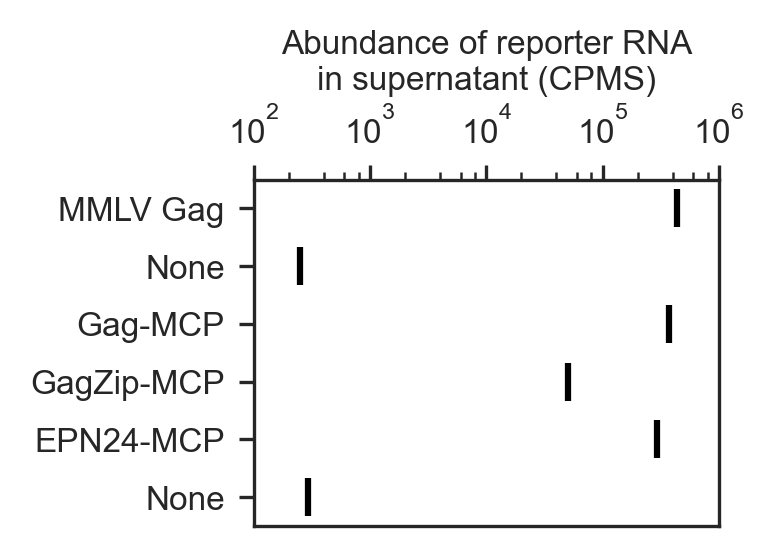

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(2,1.5))

data = counts_cpm_norm_scaled.loc["mCherry"]
data = data[["sFH14_1", "sFH14_5", "sFH14_2", "sFH14_3", "sFH14_4", "sFH14_6"]]

y = range(len(data))

ax.scatter(x=data,
           y=y,
           marker="|",
           s=80,
           color="k")

ax.set_xscale("log")
ax.set_xlim(1e2, 1e6)

ax.set_ylim(-0.5, 5.5)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.invert_yaxis()

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.set_xticks([1e2, 1e3, 1e4, 1e5, 1e6])

ax.set_yticks([0, 1, 2, 3, 4, 5])
yticklabels = ["MMLV Gag", "None", "Gag-MCP", "GagZip-MCP", "EPN24-MCP", "None"]
ax.set_yticklabels(yticklabels)

ax.set_xlabel("Abundance of reporter RNA\nin supernatant (CPMS)")

save_figure(fig, "barplot_absolute_abundance_of_mCh_in_exported_RNA")

In [42]:
# Report values
data

sFH14_1    432482.772692
sFH14_5       249.707236
sFH14_2    375410.175509
sFH14_3     50477.695687
sFH14_4    290962.260495
sFH14_6       290.816616
Name: mCherry, dtype: float64

In [43]:
# Show enrichments
print("Enrichment")
print("MMLV Gag:", data["sFH14_1"] / data["sFH14_5"])
print("Gag-MCP:", data["sFH14_2"] / data["sFH14_6"])
print("GagZip-MCP:", data["sFH14_3"] / data["sFH14_6"])
print("EPN24-MCP:", data["sFH14_4"] / data["sFH14_6"])

Enrichment
MMLV Gag: 1731.9593100975885
Gag-MCP: 1290.8828270449012
GagZip-MCP: 173.5722544621159
EPN24-MCP: 1000.5008118954255


# Plot enrichment of endogenous (off-target) RNA in supernatant

## Calculate enrichment of endogenous RNA

To estimate the contribution of non-transgene RNA, we perform a similar calculation to that described above.

Let $n$ be the number of molecules of spike-in and $m$ be the number of molecules of cellular origin.

Let $r$ be the number of transgene molecules and $s$ be the number of natural non-transgene molecules, so that $m = r + s$.

$n$ is equal across samples. 

Our goal is to estimate $s$.


Reads can be partitioned into the fraction of spike-in reads $x_n$ and the fraction of cellular reads $x_m = 1 - x_n$.

Further, the cellular reads can be partitioned into the fraction of transgene reads $x_r$ and non-transgene reads $x_s$, such that $x_m = x_r + x_s$.

The ratio of spike-in reads to non-transgene reads is proportional to the ratio of the number of spike-in molecules to non-transgene molecules:

$\frac{n}{s} = \frac{x_n}{x_s}$

We can rearrange this expression to obtain an estimate of $m$:

$s = \frac{x_s}{x_n}n$.

Comparing two samples, denoted by subscripts $+$ and $-$, the fold-change in $s$ is:

$\frac{s_+}{s_-} = \frac{ \frac{x_{s+}}{x_{n+}} n} { \frac{x_{s-}}{x_{n-}} n} = \frac{ \frac{x_{s+}}{x_{n+}}} { \frac{x_{s-}}{x_{n-}}}$.

In [44]:
# Get fraction of reads from spike-in and from endogenous (non-transgenic) RNA

frac_ERCC = counts_cpm.loc[names_ERCC].sum() / 1e6  # x_n, fraction ERCCs
frac_natural = counts_cpm.drop(names_ERCC).drop(names_transgenes).sum() / 1e6  # x_s, fraction natural genes (non-transgenes)

print("Fraction ERCC\n", frac_ERCC)
print()

print("Fraction endogenous RNA\n", frac_natural)
print()

Fraction ERCC
 sFH14_1    0.087281
sFH14_2    0.438366
sFH14_3    0.933832
sFH14_4    0.735951
sFH14_5    0.971013
sFH14_6    0.973176
sFH14_7    0.979281
sFH14_8    0.986465
dtype: float64

Fraction endogenous RNA
 sFH14_1    0.868611
sFH14_2    0.396651
sFH14_3    0.018496
sFH14_4    0.046111
sFH14_5    0.028034
sFH14_6    0.025764
sFH14_7    0.020719
sFH14_8    0.013535
dtype: float64



In [45]:
# Calculate enrichment

enrichment_natural_exporter_over_no_exporter = pd.DataFrame(columns=["enrichment"])

enrichment_natural_exporter_over_no_exporter.loc["Gag", "enrichment"] = (frac_natural["sFH14_1"] / frac_ERCC["sFH14_1"]) / (frac_natural["sFH14_5"] / frac_ERCC["sFH14_5"])
enrichment_natural_exporter_over_no_exporter.loc["Gag-MCP", "enrichment"] = (frac_natural["sFH14_2"] / frac_ERCC["sFH14_2"]) / (frac_natural["sFH14_6"] / frac_ERCC["sFH14_6"])
enrichment_natural_exporter_over_no_exporter.loc["GagZip-MCP", "enrichment"] = (frac_natural["sFH14_3"] / frac_ERCC["sFH14_3"]) / (frac_natural["sFH14_6"] / frac_ERCC["sFH14_6"])
enrichment_natural_exporter_over_no_exporter.loc["EPN24-MCP", "enrichment"] = (frac_natural["sFH14_4"] / frac_ERCC["sFH14_4"]) / (frac_natural["sFH14_6"] / frac_ERCC["sFH14_6"])

# Reorder rows
index_ordered = ["Gag", "Gag-MCP", "GagZip-MCP", "EPN24-MCP"]
enrichment_natural_exporter_over_no_exporter = enrichment_natural_exporter_over_no_exporter.loc[index_ordered]

enrichment_natural_exporter_over_no_exporter = enrichment_natural_exporter_over_no_exporter.reset_index()

enrichment_natural_exporter_over_no_exporter

,index,enrichment
0,Gag,344.709426
1,Gag-MCP,34.178168
2,GagZip-MCP,0.748148
3,EPN24-MCP,2.36664


In [46]:
# Calculate enrichment with confidence intervals based on binomial sampling

# Sample reads and calculate enrichment at 5 and 95 percentiles

counts_temp = counts_raw.copy()  # work with a copy of the counts, so we don't touch the raw counts
counts_temp = counts_temp.drop(names_unmapped, axis=0)  # Drop symbols for mapping reporting

num_reads = counts_temp.sum()  # total reads

##### Sample reads for ERCCs

# Calculate fraction of ERCC
num_reads_ERCC = counts_temp.loc[names_ERCC].sum()  # ERCC reads
frac_ERCC_temp = num_reads_ERCC / num_reads  # fraction ERCC

# Binomial sample of reads
num_samples = 1000
reads_ERCC_sampled = np.random.binomial(num_reads, frac_ERCC_temp, size=(num_samples, num_reads.shape[0]))

# Calculate 5 and 95 percentile
reads_ERCC_sampled_lower = np.percentile(reads_ERCC_sampled, 5, axis=0)
reads_ERCC_sampled_upper = np.percentile(reads_ERCC_sampled, 95, axis=0)

# Convert to fraction of ERCC reads
frac_ERCC_sampled_lower = reads_ERCC_sampled_lower / num_reads
frac_ERCC_sampled_upper = reads_ERCC_sampled_upper / num_reads

##### Sample reads for cellular non-transgenic RNA

# Calculate fraction of non-transgenic RNA
num_reads_natural = counts_temp.drop(names_ERCC).drop(names_transgenes).sum()  # natural, non-transgenic reads
frac_natural_temp = num_reads_natural / num_reads  # fraction natural

# Binomial sample of reads
num_samples = 1000
reads_natural_sampled = np.random.binomial(num_reads, frac_natural_temp, size=(num_samples, num_reads.shape[0]))

# Calculate 5 and 95 percentile
reads_natural_sampled_lower = np.percentile(reads_natural_sampled, 5, axis=0)
reads_natural_sampled_upper = np.percentile(reads_natural_sampled, 95, axis=0)

# Convert to fraction of natural reads
frac_natural_sampled_lower = reads_natural_sampled_lower / num_reads
frac_natural_sampled_upper = reads_natural_sampled_upper / num_reads

# Calculate enrichment
enrichment_natural_exporter_over_no_exporter = pd.DataFrame(columns=["enrichment"])

enrichment_natural_exporter_over_no_exporter.loc["Gag", "enrichment"] = (frac_natural["sFH14_1"] / frac_ERCC["sFH14_1"]) / (frac_natural["sFH14_5"] / frac_ERCC["sFH14_5"])
enrichment_natural_exporter_over_no_exporter.loc["Gag-MCP", "enrichment"] = (frac_natural["sFH14_2"] / frac_ERCC["sFH14_2"]) / (frac_natural["sFH14_6"] / frac_ERCC["sFH14_6"])
enrichment_natural_exporter_over_no_exporter.loc["GagZip-MCP", "enrichment"] = (frac_natural["sFH14_3"] / frac_ERCC["sFH14_3"]) / (frac_natural["sFH14_6"] / frac_ERCC["sFH14_6"])
enrichment_natural_exporter_over_no_exporter.loc["EPN24-MCP", "enrichment"] = (frac_natural["sFH14_4"] / frac_ERCC["sFH14_4"]) / (frac_natural["sFH14_6"] / frac_ERCC["sFH14_6"])

# Calculate enrichment confidence intervals

enrichment_natural_exporter_over_no_exporter.loc["Gag", "enrichment_ci_upper"] = (frac_natural_sampled_lower["sFH14_1"] / frac_ERCC_sampled_lower["sFH14_1"]) / (frac_natural_sampled_lower["sFH14_5"] / frac_ERCC_sampled_lower["sFH14_5"])
enrichment_natural_exporter_over_no_exporter.loc["Gag", "enrichment_ci_lower"] = (frac_natural_sampled_upper["sFH14_1"] / frac_ERCC_sampled_upper["sFH14_1"]) / (frac_natural_sampled_upper["sFH14_5"] / frac_ERCC_sampled_upper["sFH14_5"])

enrichment_natural_exporter_over_no_exporter.loc["Gag-MCP", "enrichment_ci_upper"] = (frac_natural_sampled_lower["sFH14_2"] / frac_ERCC_sampled_lower["sFH14_2"]) / (frac_natural_sampled_lower["sFH14_6"] / frac_ERCC_sampled_lower["sFH14_6"])
enrichment_natural_exporter_over_no_exporter.loc["Gag-MCP", "enrichment_ci_lower"] = (frac_natural_sampled_upper["sFH14_2"] / frac_ERCC_sampled_upper["sFH14_2"]) / (frac_natural_sampled_upper["sFH14_6"] / frac_ERCC_sampled_upper["sFH14_6"])

enrichment_natural_exporter_over_no_exporter.loc["GagZip-MCP", "enrichment_ci_upper"] = (frac_natural_sampled_lower["sFH14_3"] / frac_ERCC_sampled_lower["sFH14_3"]) / (frac_natural_sampled_lower["sFH14_6"] / frac_ERCC_sampled_lower["sFH14_6"])
enrichment_natural_exporter_over_no_exporter.loc["GagZip-MCP", "enrichment_ci_lower"] = (frac_natural_sampled_upper["sFH14_3"] / frac_ERCC_sampled_upper["sFH14_3"]) / (frac_natural_sampled_upper["sFH14_6"] / frac_ERCC_sampled_upper["sFH14_6"])

enrichment_natural_exporter_over_no_exporter.loc["EPN24-MCP", "enrichment_ci_upper"] = (frac_natural_sampled_lower["sFH14_4"] / frac_ERCC_sampled_lower["sFH14_4"]) / (frac_natural_sampled_lower["sFH14_6"] / frac_ERCC_sampled_lower["sFH14_6"])
enrichment_natural_exporter_over_no_exporter.loc["EPN24-MCP", "enrichment_ci_lower"] = (frac_natural_sampled_upper["sFH14_4"] / frac_ERCC_sampled_upper["sFH14_4"]) / (frac_natural_sampled_upper["sFH14_6"] / frac_ERCC_sampled_upper["sFH14_6"])

enrichment_natural_exporter_over_no_exporter["enrichment_ci_size"] = (enrichment_natural_exporter_over_no_exporter["enrichment_ci_upper"] - enrichment_natural_exporter_over_no_exporter["enrichment_ci_lower"])/2

# Reorder rows
index_ordered = ["Gag", "Gag-MCP", "GagZip-MCP", "EPN24-MCP"]
enrichment_natural_exporter_over_no_exporter = enrichment_natural_exporter_over_no_exporter.loc[index_ordered]

enrichment_natural_exporter_over_no_exporter = enrichment_natural_exporter_over_no_exporter.reset_index()

enrichment_natural_exporter_over_no_exporter

,index,enrichment,enrichment_ci_upper,enrichment_ci_lower,enrichment_ci_size
0,Gag,344.709426,346.109953,343.352889,1.378532
1,Gag-MCP,34.178168,34.270478,34.083375,0.093551
2,GagZip-MCP,0.748148,0.747878,0.748349,-0.000236
3,EPN24-MCP,2.36664,2.369121,2.364128,0.002496


## Plot enrichment of endogenous RNA in supernatant RNA

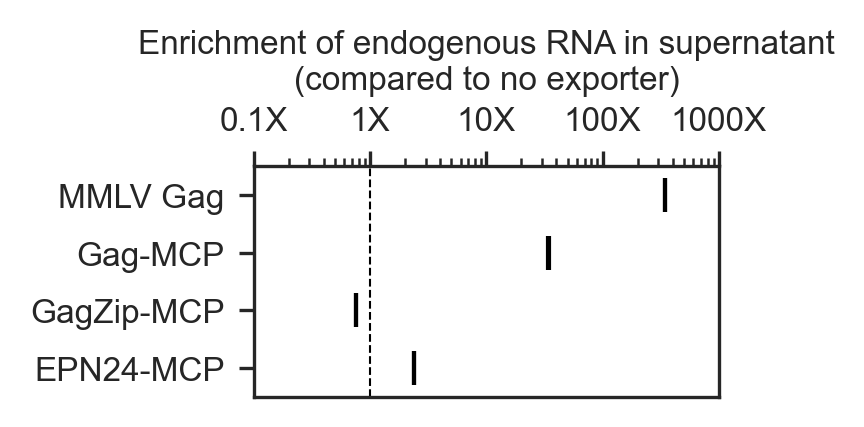

In [47]:
data = enrichment_natural_exporter_over_no_exporter.set_index("index")

fig, ax = plt.subplots(1, 1, figsize=(2,1))

y = range(len(data["enrichment"]))
ax.errorbar(y=y,
            x=data["enrichment"],
            xerr=data["enrichment_ci_size"],
            fmt="none",
            color="k",
            capsize=4)

ax.set_xscale("log")
ax.set_xlim(1e-1, 1e3)

ax.set_ylim(-0.5, 3.5)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.invert_yaxis()

ax.set_yticks([0, 1, 2, 3])
yticklabels = ["MMLV Gag", "Gag-MCP", "GagZip-MCP", "EPN24-MCP"]
ax.set_yticklabels(yticklabels)

ax.set_xticks([1e-1, 1, 1e1, 1e2, 1e3])
xticklabels = ["0.1X", "1X", "10X", "100X", "1000X"]
ax.set_xticklabels(xticklabels)

ax.set_xlabel("Enrichment of endogenous RNA in supernatant\n(compared to no exporter)")

ax.axvline(1, ls="--", lw=0.5, color="k")

save_figure(fig, "barplot_enrichment_of_endogenous_RNA_in_exported_RNA", savefig_args=savefig_args)

In [48]:
# Report values
data

,enrichment,enrichment_ci_upper,enrichment_ci_lower,enrichment_ci_size
index,,,,
Gag,344.709426,346.109953,343.352889,1.378532
Gag-MCP,34.178168,34.270478,34.083375,0.093551
GagZip-MCP,0.748148,0.747878,0.748349,-0.000236
EPN24-MCP,2.36664,2.369121,2.364128,0.002496


# Plot genome-wide profiling of abundance in supernatant with exporter vs no exporter

In [49]:
# Set plotting parameters

# Set gene colors
gene_to_color = {"mCherry": "#db6aa9", "EGFP": "#33a02c", "mTagBFP2": "#969696"}

# Set gene markers
gene_to_marker = {"mCherry": "*", "EGFP": "hexagon2", "mTagBFP2": "o"}

In [50]:
# Define plotting function

def plot_pretty_density(ax, data, name1, name2):
    """ Plot density of name1 against name 2 """

    y = data[name1]
    x = data[name2]
    bins = np.logspace(0,6,100)
    h = ax.hist2d(x, y,
                  bins=bins,
                  norm=mpl.colors.LogNorm(vmin=1, vmax=100),
                  cmap="viridis")

    y = data[name1].loc["mCherry"]
    x = data[name2].loc["mCherry"]
    ax.scatter(x, y, marker=gene_to_marker["mCherry"], color=gene_to_color["mCherry"], zorder=10, s=80)

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(1e0, 1e6)
    ax.set_ylim(1e0, 1e6)

    # Ratio lines
    lw = 0.5
    ax.plot([1e-1, 1e6], [1e-1, 1e6], linestyle="--", color="k", lw=lw)
    ax.plot([1e-1, 1e6], [1e0, 1e7], linestyle="--", color="k", lw=lw)
    ax.plot([1e-1, 1e6], [1e1, 1e8], linestyle="--", color="k", lw=lw)
    ax.plot([1e-1, 1e6], [1e2, 1e9], linestyle="--", color="k", lw=lw)
    ax.plot([1e-1, 1e6], [1e3, 1e10], linestyle="--", color="k", lw=lw)
    
    # Force tick positions
    locmaj = mpl.ticker.LogLocator(base=10,numticks=12)
    ax.xaxis.set_major_locator(locmaj)
    ax.yaxis.set_major_locator(locmaj)
    locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    # Label ratio lines
    ax2 = ax.twiny()
    ax2.set_xlim(1e0, 1e6)
    ax2.set_xscale("log")
    ax2.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
    ax2.set_xticklabels(["", "", "$10^4$", "$10^3$", "$10^2$", "$10^1$", "1"])
    
    return ax, ax2

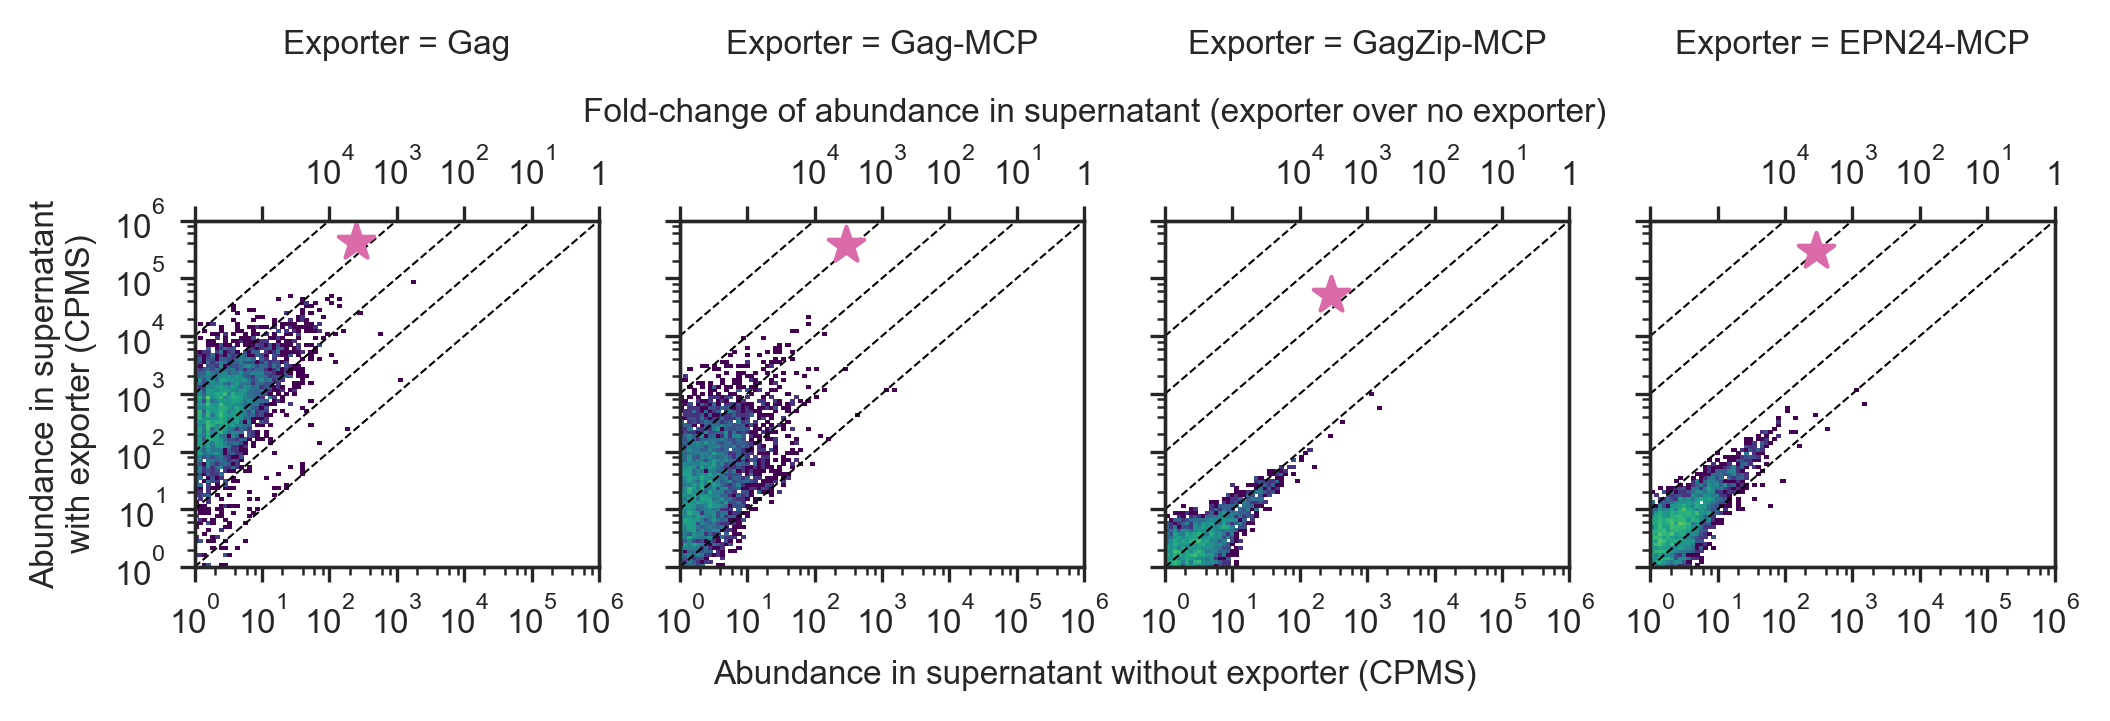

In [51]:
# Plot

names_drop = names_ERCC + ["mTagBFP2", "EGFP"]

fig, axes = plt.subplots(1, 4, figsize=(8,1.5), sharey=True)

pad_title = 40

ax = axes[0]
name1 = "sFH14_1"
name2 = "sFH14_5"
data = counts_cpm_norm_scaled.drop(names_drop)
plot_pretty_density(ax, data, name1, name2)
ax.set_title("Exporter = Gag", pad=pad_title)

ax = axes[1]
name1 = "sFH14_2"
name2 = "sFH14_6"
data = counts_cpm_norm_scaled.drop(names_drop)
plot_pretty_density(ax, data, name1, name2)
ax.set_title("Exporter = Gag-MCP", pad=pad_title)

ax = axes[2]
name1 = "sFH14_3"
name2 = "sFH14_6"
data = counts_cpm_norm_scaled.drop(names_drop)
plot_pretty_density(ax, data, name1, name2)
ax.set_title("Exporter = GagZip-MCP", pad=pad_title)

ax = axes[3]
name1 = "sFH14_4"
name2 = "sFH14_6"
data = counts_cpm_norm_scaled.drop(names_drop)
plot_pretty_density(ax, data, name1, name2)
ax.set_title("Exporter = EPN24-MCP", pad=pad_title)

axes[0].set_ylabel("Abundance in supernatant\nwith exporter (CPMS)")
fig.text(0.5, -0.15, "Abundance in supernatant without exporter (CPMS)", ha="center")
fig.text(0.5, 1.1, "Fold-change of abundance in supernatant (exporter over no exporter)", ha="center")

save_figure(fig, "density_exporter_vs_no_exporter")

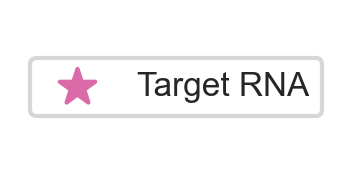

In [52]:
# Plot legend

fig, ax = plt.subplots(1, 1, figsize=(1,0.5))

ax.scatter(0, 0,
           color=gene_to_color["mCherry"],
           marker=gene_to_marker["mCherry"],
           label="Target RNA", s=80)

ax.axis('off')
ax.set_xlim(1, 2)

fig.legend(loc="center")

save_figure(fig, "density_exporter_vs_no_exporter_legend")

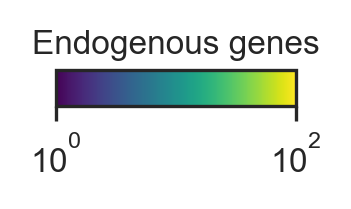

In [53]:
# Plot only colorbar with horizontal orientation

fig, ax = plt.subplots(1, 1, figsize=(1,0.2))

dummy = np.array([[1,100]])  # dummy data
img = plt.imshow(dummy, norm=mpl.colors.LogNorm(vmin=1, vmax=100), cmap="viridis")
plt.gca().set_visible(False)  # hide plot
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax, label="Endogenous genes", pad=0.1)
cbar.ax.xaxis.set_label_position("top")

save_figure(fig, "density_exporter_vs_no_exporter_colorbar")

# Plot full distribution across genes of enrichment in supernatant with exporter versus no exporter 

## Calculate enrichment (fold-change) with versus without exporter

In [54]:
# Calculate enrichment (fold-change) with exporter versus without exporter

# Create new dataframe
fc = pd.DataFrame()

# Calculate fold-change

names_samples = [("Gag", "sFH14_1", "sFH14_5"),
                 ("Gag-MCP", "sFH14_2", "sFH14_6"),
                 ("GagZip-MCP", "sFH14_3", "sFH14_6"),
                 ("EPN24-MCP", "sFH14_4", "sFH14_6")]

for name, sample1, sample2 in names_samples:

    x = counts_cpm_norm[sample1]
    y = counts_cpm_norm[sample2]
    fc[name] = x/y
    
# Drop infinite and nan values
fc_clean = fc.replace([np.inf, -np.inf], np.nan)  # replace infinite values with nan
fc_clean = fc_clean.dropna()  # drop nan

print(fc_clean.shape)
fc_clean.head()


(6425, 4)


,Gag,Gag-MCP,GagZip-MCP,EPN24-MCP
symbol_ensembl,,,,
TSPAN6_ENSG00000000003,1608.447716,189.676397,1.577796,2.466233
DPM1_ENSG00000000419,361.954280,38.548317,0.000000,6.010080
NFYA_ENSG00000001167,8966.875892,190.354021,4.284996,5.143763
NIPAL3_ENSG00000001461,2984.730675,79.941676,2.583757,1.967958
LAS1L_ENSG00000001497,168.635545,227.933500,1.922594,13.345480


In [55]:
# Calculate log fold change
fc_clean_log = fc_clean.apply(np.log10)

# Remove infinite values
fc_clean_log = fc_clean_log.replace([np.inf, -np.inf], np.nan)  # replace infinite values with nan
fc_clean_log = fc_clean_log.dropna()  # drop nan

print(fc_clean_log.shape)
fc_clean_log.head()

(4802, 4)


,Gag,Gag-MCP,GagZip-MCP,EPN24-MCP
symbol_ensembl,,,,
TSPAN6_ENSG00000000003,3.206407,2.278013,0.198051,0.392034
NFYA_ENSG00000001167,3.952641,2.279562,0.631950,0.711281
NIPAL3_ENSG00000001461,3.474905,1.902773,0.412252,0.294016
LAS1L_ENSG00000001497,2.226949,2.357808,0.283887,1.125334
CD99_ENSG00000002586,3.227859,1.181412,-1.081260,-1.090351


In [56]:
# Filter to remove genes that are lowly detected (CPM < 10)

counts_cutoff = 10

names_samples = [("Gag", "sFH14_1", "sFH14_5"),
                 ("Gag-MCP", "sFH14_2", "sFH14_6"),
                 ("GagZip-MCP", "sFH14_3", "sFH14_6"),
                 ("EPN24-MCP", "sFH14_4", "sFH14_6")]

names = []
vals = []

for name, sample1, sample2 in names_samples:
    
    selector = (counts_cpm_norm[sample1] > counts_cutoff) & (counts_cpm_norm[sample2] > counts_cutoff)
    genes_filtered = set(counts_cpm_norm.loc[selector].index).intersection(set(fc_clean_log.index))
    vals_ = fc_clean_log[name]

    vals.extend(vals_)
    names.extend([name]*len(vals_))

# Create dataframe
data = pd.DataFrame(data={"name": names, "log10_fc": vals})

print(data.shape)
data.head()

(19208, 2)


,name,log10_fc
0,Gag,3.206407
1,Gag,3.952641
2,Gag,3.474905
3,Gag,2.226949
4,Gag,3.227859


## Plot distribution of enrichment with versus without exporter

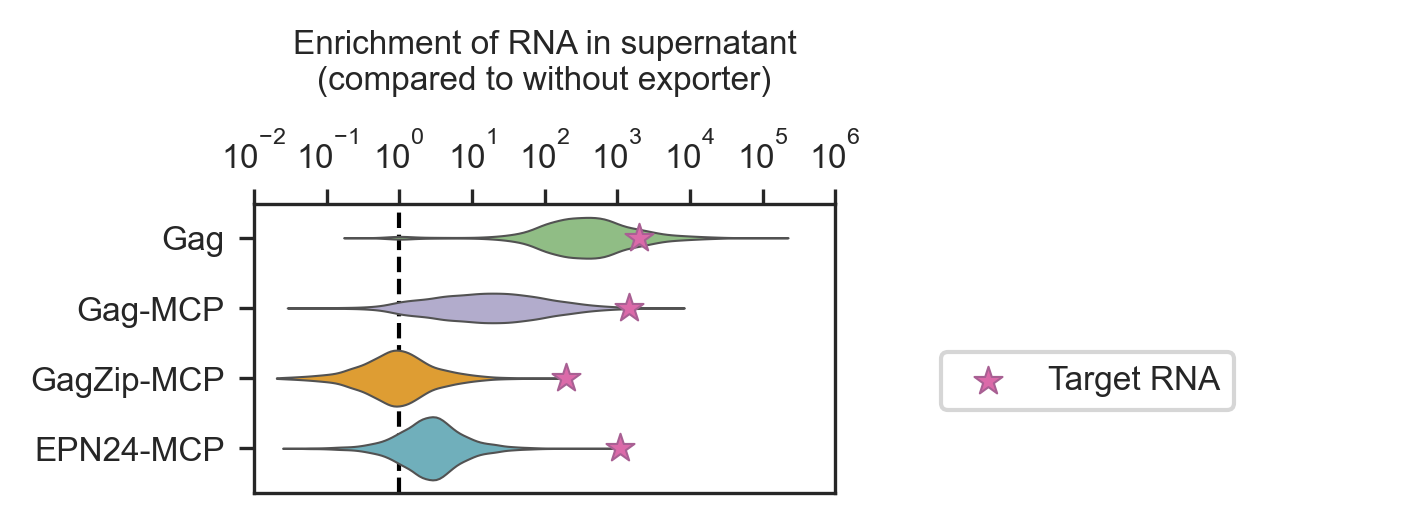

In [57]:
# Plot distribution

fig, ax = plt.subplots(1, 1, figsize=(2.5,1.25))

color = [sample_to_color[_[1]] for _ in names_samples]

palette = ["#8ac67c", "#aea7d1", "#faa417", "#63b8c8"]

sns.violinplot(ax=ax,
               data=data,
               x="log10_fc",
               y="name",
               orient="h",
               cut=0,
               width=0.9,
               linewidth=0.5,
               inner=None,
               # color="#999999"
               palette=palette
              )

for y, name in enumerate(["Gag", "Gag-MCP", "GagZip-MCP", "EPN24-MCP"]):
    x = fc_clean_log.loc["mCherry", name]
    if y == 0:
        # Show label for first scatter
        ax.scatter(x, y, color="#db6aa9", edgecolor="#a86093", linewidth=0.5, marker=gene_to_marker["mCherry"], s=50, zorder=10, label="Target RNA")
    else:
        ax.scatter(x, y, color="#db6aa9", edgecolor="#a86093", linewidth=0.5, marker=gene_to_marker["mCherry"], s=50, zorder=10)
    
ax.set_xlim(-2,6)

ax.set_xlabel("Enrichment of RNA in supernatant\n(compared to without exporter)", labelpad=10)
ax.set_ylabel("")
ax.set_yticklabels(["Gag", "Gag-MCP", "GagZip-MCP", "EPN24-MCP"])

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.set_xticks([-2, -1, 0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(["$10^{-2}$", "$10^{-1}$", "$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$", "$10^6$"])

ax.axvline(0, color="k", ls="--", lw=1, zorder=-1)

# Legend
fig.legend(loc="upper center", bbox_to_anchor=(1.45, 0.5))

save_figure(fig, "violin_genome_wide_enrichment")

In [58]:
# Report stats
print(scipy.stats.mannwhitneyu(data.set_index("name").loc["Gag"], data.set_index("name").loc["Gag-MCP"]))
print(scipy.stats.mannwhitneyu(data.set_index("name").loc["Gag-MCP"], data.set_index("name").loc["GagZip-MCP"]))
print(scipy.stats.mannwhitneyu(data.set_index("name").loc["GagZip-MCP"], data.set_index("name").loc["EPN24-MCP"]))
print(scipy.stats.mannwhitneyu(data.set_index("name").loc["Gag-MCP"], data.set_index("name").loc["EPN24-MCP"]))

MannwhitneyuResult(statistic=array([20821176.]), pvalue=array([0.]))
MannwhitneyuResult(statistic=array([21037392.]), pvalue=array([0.]))
MannwhitneyuResult(statistic=array([5460297.]), pvalue=array([0.]))
MannwhitneyuResult(statistic=array([18605898.]), pvalue=array([0.]))
